# Introduction

In the previous notebboks, we try to classify song based on audio signal using differents methods. Now, we will explore meta-data provided with the dataset. For now we will use only the reduced one with only 8k song but if the result is good, another  notebbok will be setup with the full dataset.

With the dataset we have 2 metadata: 

- The first one is provided by Echo Nest. It provides different features like acousticness ou speechness which evaluate song with specific factors. Unfortunately, echonest has been bought by Spotify and the API is not availabel for songs out of Spotify. By luck, it exists <a href="https://traktomizer.com/product/traktomizer/">Traktomizer</a> which do nearly the same.

- The second one can be computed easily with librosa. It's a group of feature extracted from the audio like the cqt or the sftf of the song. 

In addition of the missing access to echonest API, we have plenty of missing data with this dataset so we will only use the extracted features.

# Loading datas

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import librosa
import random
import time 
import pickle
import queue
import threading

from scipy import signal
from scipy.spatial.distance import cdist

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

import IPython.display as ipd

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

%matplotlib inline

pd.set_option('max_info_columns', 999)

def swish(x):
    return x*K.sigmoid(x)

get_custom_objects().update({'custom_activation': swish})

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Tracks

In [2]:
tracks = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/tracks.csv", 
                     header=[0, 1], 
                     skipinitialspace=True, 
                     index_col=0, 
                    encoding = "ISO-8859-1")
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
140             1  2008-11-26 01:49:59  2007-05-22 00:00:00      NaN   
141             0  2008-11-26 01:49:57  2009-01-16 00:00:00      NaN   

                                                                           \
         favorites  id                                        information   
track_id                                                                    
2                4   1                                            <p></p>   
5                4   1                                            <p></p>   
10               4   6                                                NaN   
140              1  61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...   
141              1  60  <p>A full ensamble of strings, drums, electron...   

                                                              ...          \
         listens                        producer tags         ...           
track_id                                                      ...           
2           6073                             NaN   []         ...           
5           6073                             NaN   []         ...           
10         47632                             NaN   []         ...           
140         1300  Alec K. Refearn, Rob Pemberton   []         ...           
141         1304                             NaN   []         ...           

               track                         \
         information interest language_code   
track_id                                      
2                NaN     4656            en   
5                NaN     1933            en   
10               NaN    54881            en   
140              NaN     1593            en   
141              NaN      839            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
140       Attribution-Noncommercial-No Derivative Works ...    1299      NaN   
141       Attribution-Noncommercial-No Derivative Works ...     725      NaN   

                                                    
         number publisher tags               title  
track_id                                            
2             3       NaN   []                Food  
5             6       NaN   []          This World  
10            1       NaN   []             Freeway  
140           2       NaN   []  Queen Of The Wires  
141           4       NaN   []                Ohio  

[5 rows x 52 columns]

On this dataset, we only need the top class for all 8k songs, this is for our y label

In [3]:
tracks = tracks[[ ("track", "genre_top") ]]

### Echonest data

In [4]:
echonest = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/echonest.csv", index_col=0)
echonest.head()

audio_features audio_features.1    audio_features.2  \
track_id   acousticness     danceability              energy   
2          0.4166752327     0.6758939853        0.6344762684   
5          0.0435668989     0.7455658702        0.7014699916   
10         0.9516699648     0.6581786543  0.9245251615000001   
140        0.3763124975     0.7340790229        0.2656847734   

               audio_features.3     audio_features.4      audio_features.5  \
track_id       instrumentalness             liveness           speechiness   
2          0.010628068300000001  0.17764657120000002          0.1593100648   
5         0.0006967989999999999  0.37314331240000004   0.12459534189999999   
10           0.9654270154000001         0.1154738842  0.032985219100000004   
140                0.6695811237  0.08599512220000001          0.0390682262   

         audio_features.6 audio_features.7  temporal_features  \
track_id            tempo          valence           0.000000   
2                 165.922      0.576660988           0.877233   
5                  100.26     0.6216612236           0.548093   
10                111.562     0.9635898919           0.311404   
140               107.952     0.6099912728           0.331811   

          temporal_features.1          ...            temporal_features.214  \
track_id             1.000000          ...                       214.000000   
2                    0.588911          ...                        -1.992303   
5                    0.720192          ...                        -2.288358   
10                   0.711402          ...                        -3.662988   
140                  0.312733          ...                        -0.934696   

          temporal_features.215  temporal_features.216  temporal_features.217  \
track_id             215.000000             216.000000              217.00000   
2                      6.805694               0.233070                0.19288   
5                     11.527109               0.256821                0.23782   
10                    21.508228               0.283352                0.26707   
140                   -0.260981               0.322232                0.27798   

          temporal_features.218  temporal_features.219  temporal_features.220  \
track_id             218.000000              219.00000              220.00000   
2                      0.027455                0.06408                3.67696   
5                      0.060122                0.06014                5.92649   
10                     0.125704                0.08082                8.41401   
140                    0.136747                0.07533                9.86272   

          temporal_features.221  temporal_features.222  temporal_features.223  
track_id              221.00000             222.000000             223.000000  
2                       3.61288              13.316690             262.929749  
5                       5.86635              16.013849             356.755737  
10                      8.33319              21.317064             483.403809  
140                     9.78739              21.981621             562.229431  

[5 rows x 232 columns]

In [5]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, track_id to 124186
Data columns (total 232 columns):
audio_features           1295 non-null object
audio_features.1         1295 non-null object
audio_features.2         1295 non-null object
audio_features.3         1295 non-null object
audio_features.4         1295 non-null object
audio_features.5         1295 non-null object
audio_features.6         1295 non-null object
audio_features.7         1295 non-null object
temporal_features        1295 non-null float64
temporal_features.1      1295 non-null float64
temporal_features.2      1295 non-null float64
temporal_features.3      1295 non-null float64
temporal_features.4      1295 non-null float64
temporal_features.5      1295 non-null float64
temporal_features.6      1295 non-null float64
temporal_features.7      1295 non-null float64
temporal_features.8      1295 non-null float64
temporal_features.9      1295 non-null float64
temporal_features.10     1295 non-null float64
tem

As mentionned previously, on 8k songs, we have only 1295 audio with echonest analysis. That's why we will ignore it

### Other features

In [6]:
features = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   

feature                                               ...      tonnetz  \
statistics                                            ...          std   
number            07        08        09        10    ...           04   
track_id                                              ...                
2           1.481593  2.691455  0.866868  1.341231    ...     0.054125   
5          -0.923192 -0.927232  0.666617  1.038546    ...     0.040730   
10          1.770694  1.604566  0.521217  1.982386    ...     0.074358   
140        -0.882913 -0.582376 -0.884749 -0.645214    ...     0.157683   
141        -0.204884  0.023624 -0.642770 -0.786291    ...     0.145994   

feature                               zcr                                \
statistics                       kurtosis       max      mean    median   
number            05        06         01        01        01        01   
track_id                                                                  
2           0.012226  0.012111   5.758890  0.459473  0.085629  0.071289   
5           0.012691  0.014759   6.808415  0.375000  0.053114  0.041504   
10          0.017952  0.013921  21.434212  0.452148  0.077515  0.071777   
140         0.028070  0.025946  11.052547  0.379395  0.052379  0.036621   
141         0.024342  0.032111  32.994659  0.415527  0.040267  0.034668   

feature                                   
statistics       min      skew       std  
number            01        01        01  
track_id                                  
2           0.000000  2.089872  0.061448  
5           0.000000  2.193303  0.044861  
10          0.000000  3.542325  0.040800  
140         0.001953  3.143968  0.057712  
141         0.002930  4.204097  0.028665  

[5 rows x 518 columns]

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7994 entries, 2 to 155066
Data columns (total 518 columns):
(chroma_cens, kurtosis, 01)           7994 non-null float64
(chroma_cens, kurtosis, 02)           7994 non-null float64
(chroma_cens, kurtosis, 03)           7994 non-null float64
(chroma_cens, kurtosis, 04)           7994 non-null float64
(chroma_cens, kurtosis, 05)           7994 non-null float64
(chroma_cens, kurtosis, 06)           7994 non-null float64
(chroma_cens, kurtosis, 07)           7994 non-null float64
(chroma_cens, kurtosis, 08)           7994 non-null float64
(chroma_cens, kurtosis, 09)           7994 non-null float64
(chroma_cens, kurtosis, 10)           7994 non-null float64
(chroma_cens, kurtosis, 11)           7994 non-null float64
(chroma_cens, kurtosis, 12)           7994 non-null float64
(chroma_cens, max, 01)                7994 non-null float64
(chroma_cens, max, 02)                7994 non-null float64
(chroma_cens, max, 03)                7994 non-nul

As we can see there is plenty of features. To see it more clerly, let's plot a boxplot for all group of features. This will help to see outliers

In [8]:
group = sorted(list(set([col[:2] for col in features])))

### filtering

First we can see that we don't have all data with Echonest. As a result we cannot exploit it as is. we may use it for visualization (will be done later with R) to see it there is high correlation between features and classes. But for now, we will focus on the extracted features (things we can do with librosa for free)

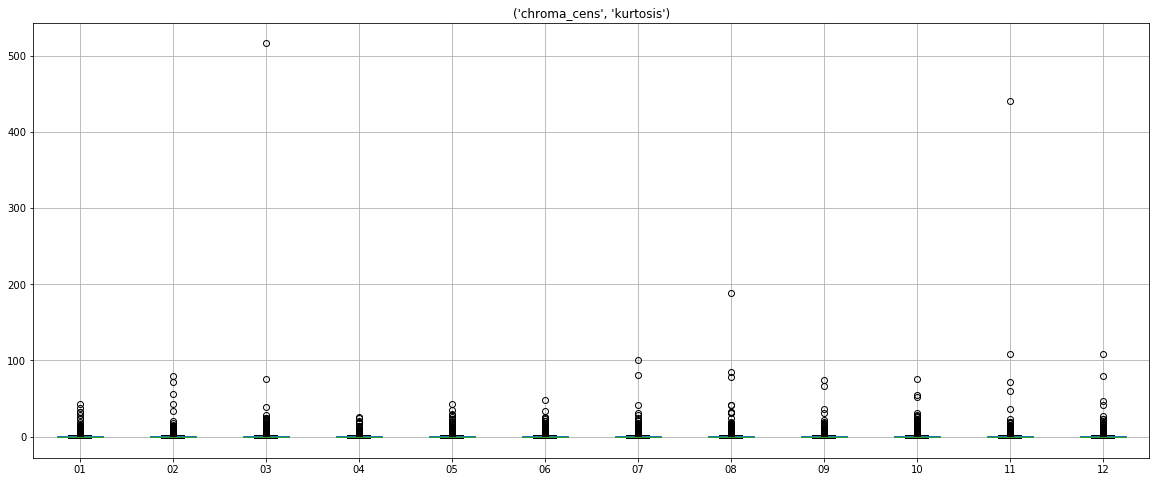

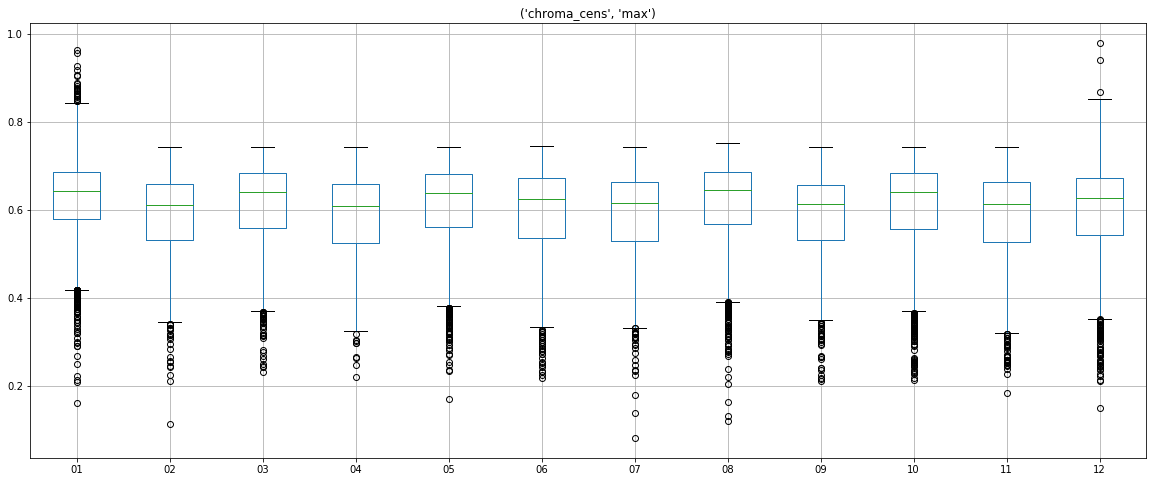

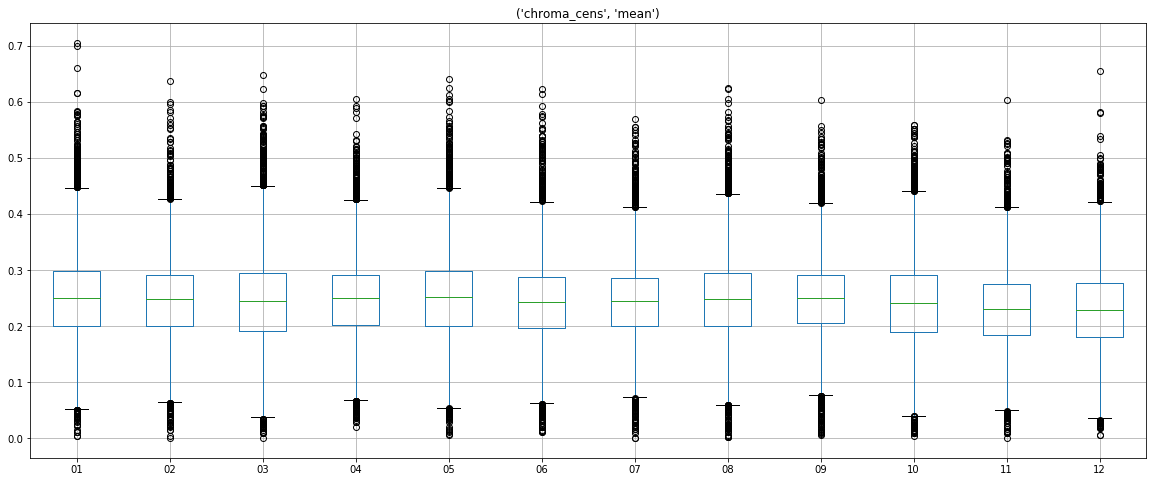

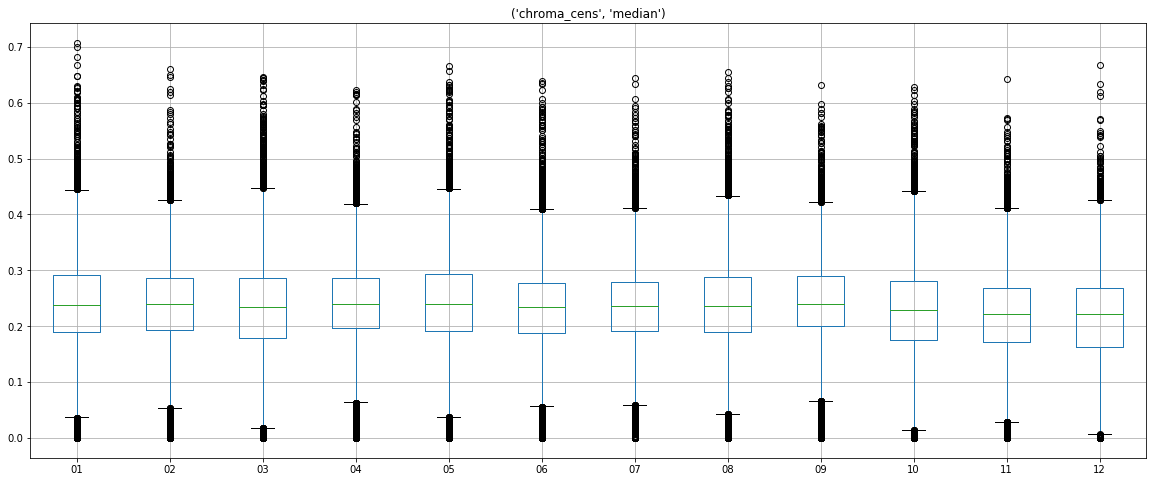

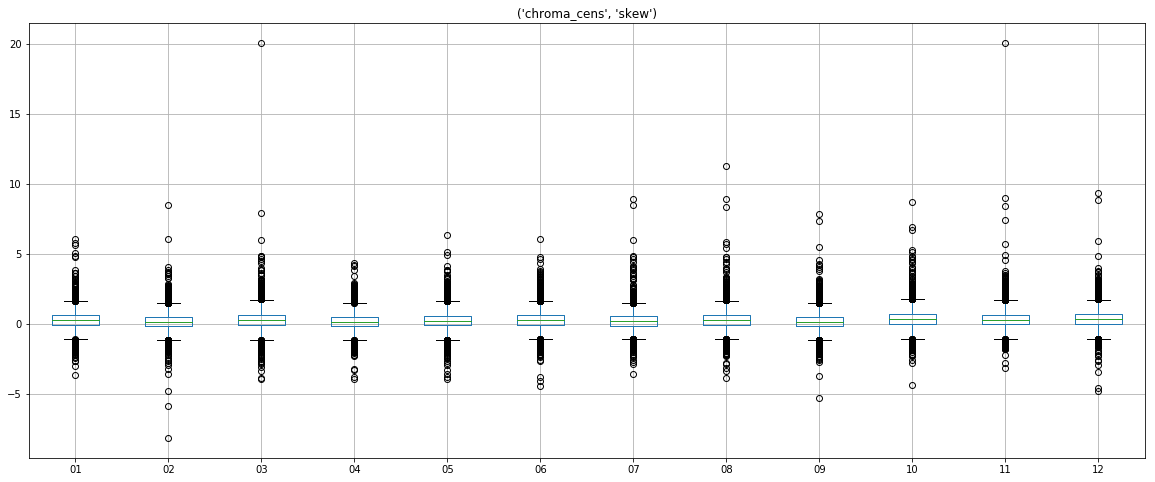

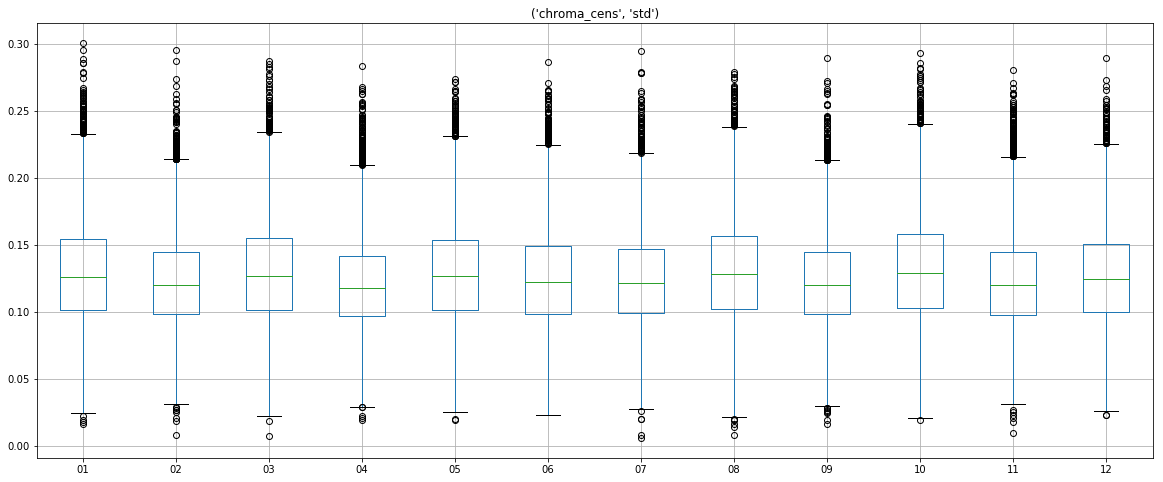

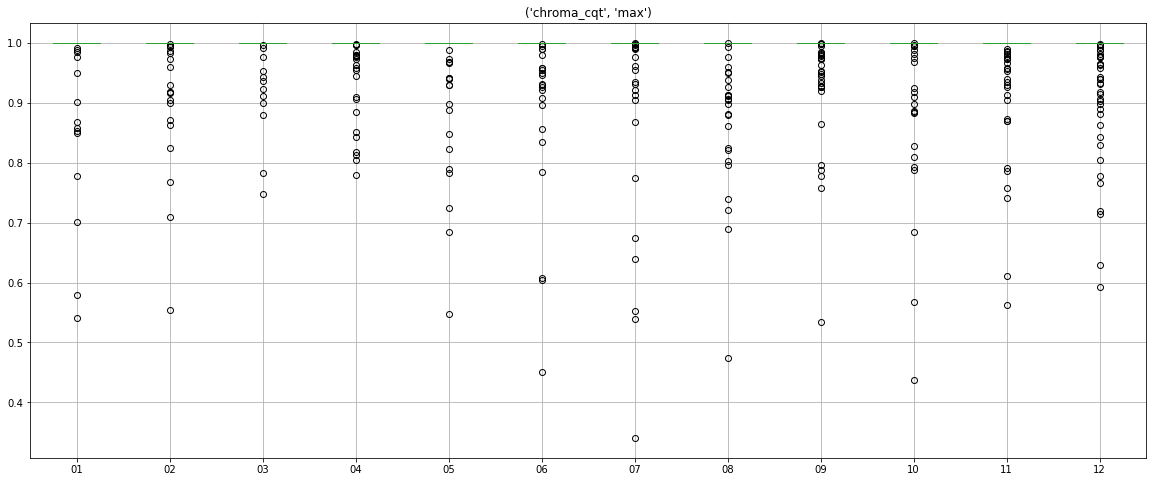

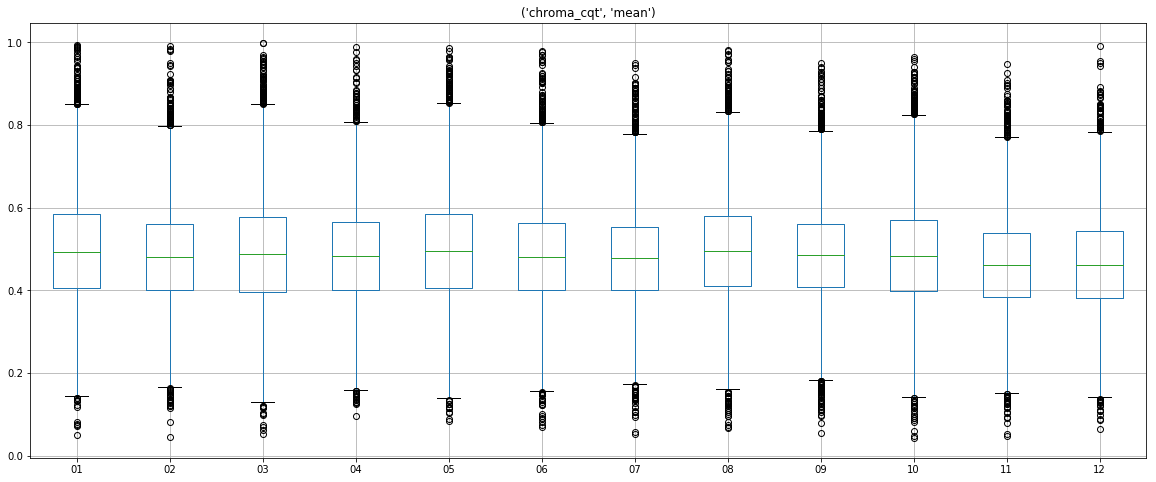

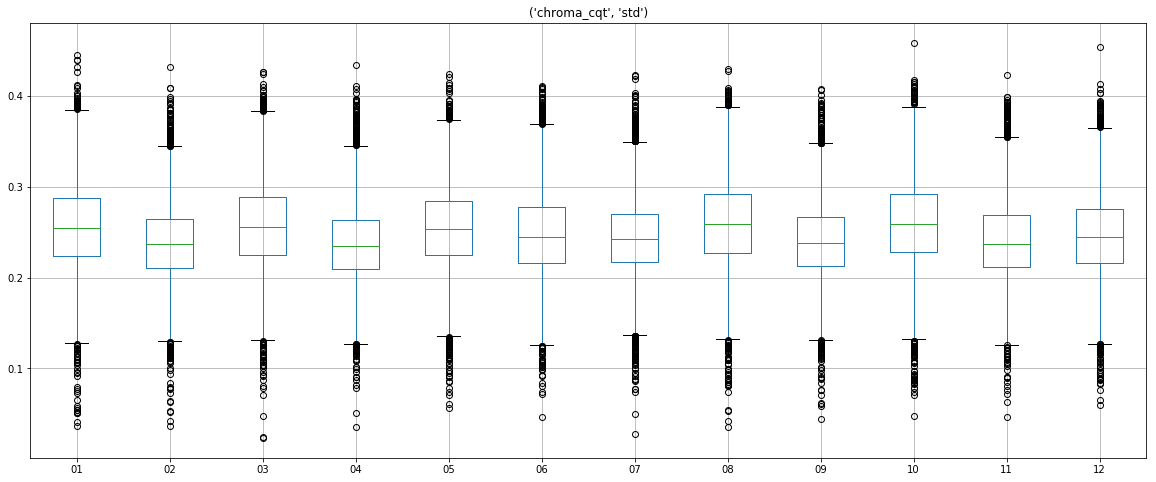

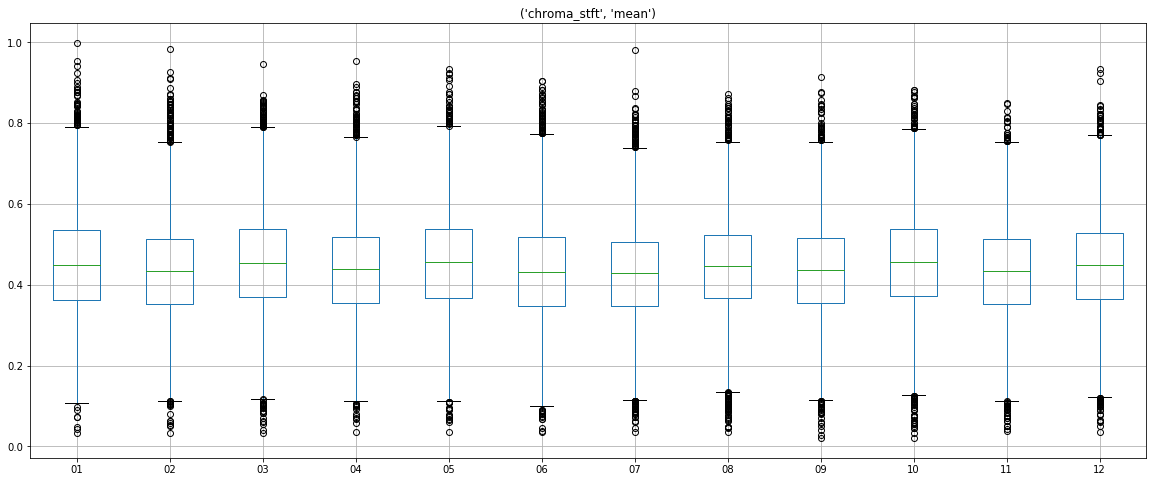

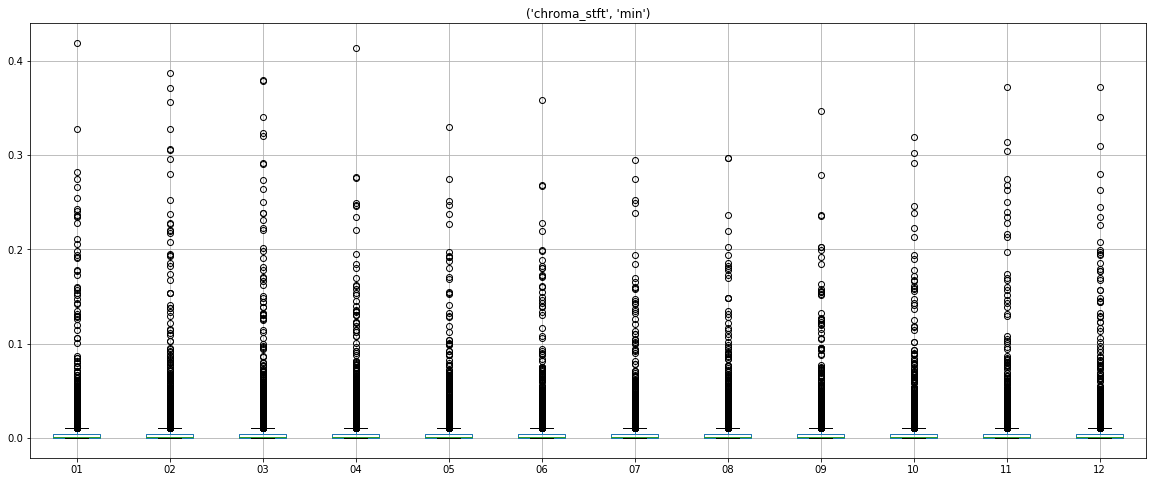

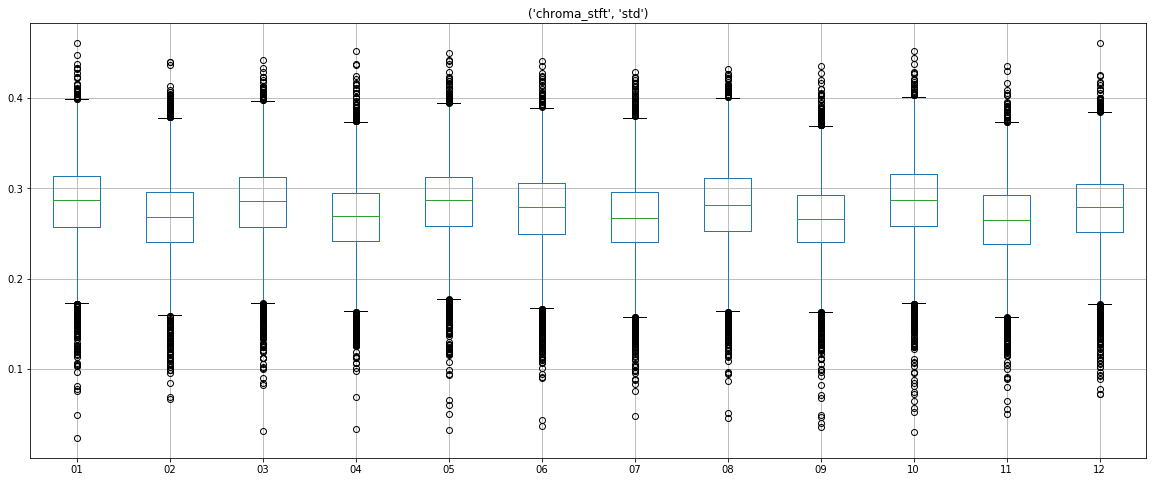

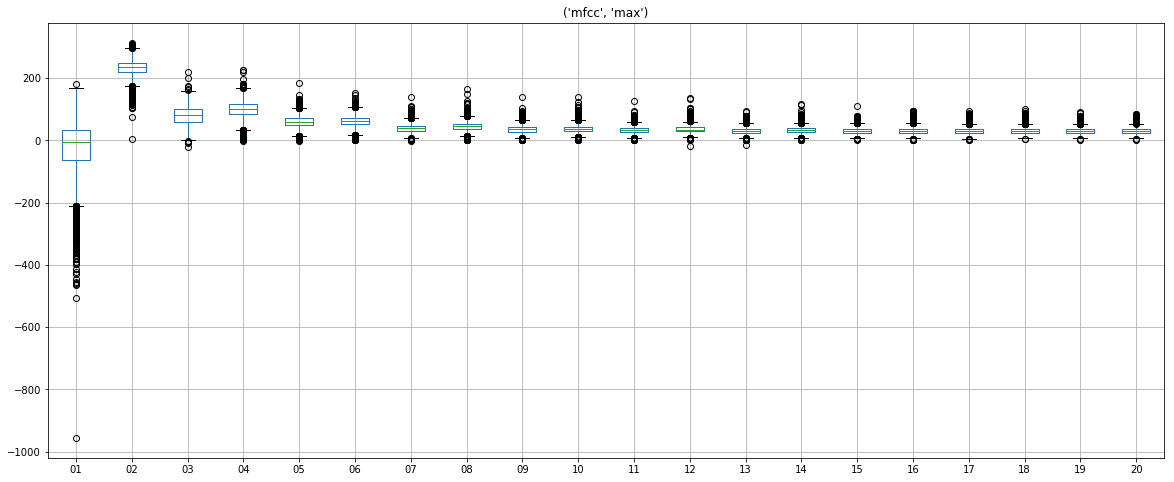

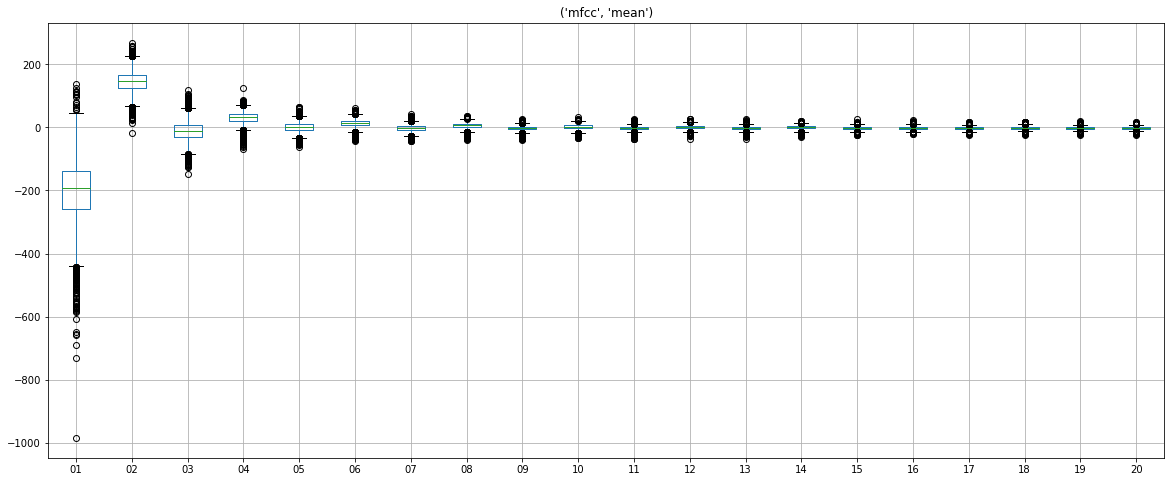

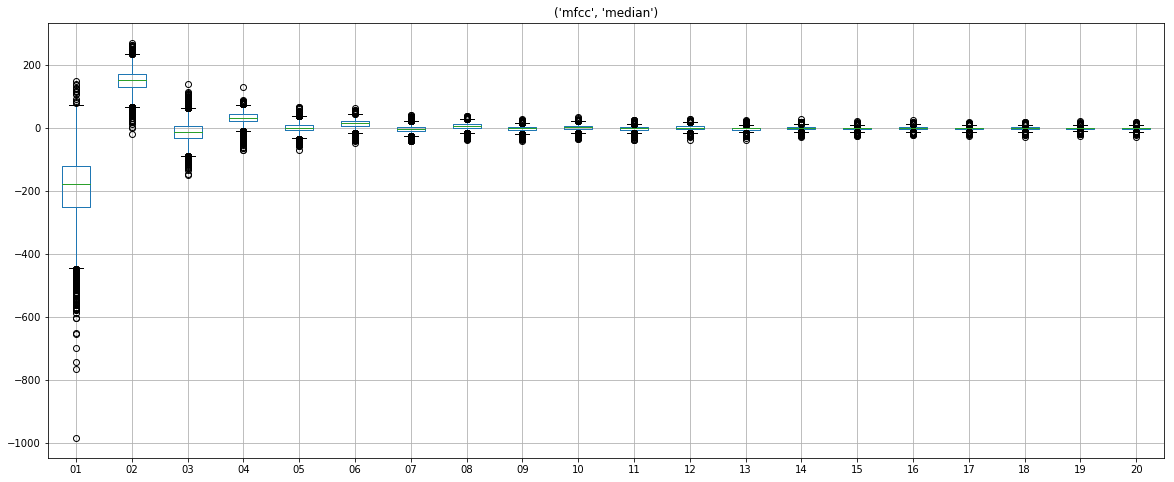

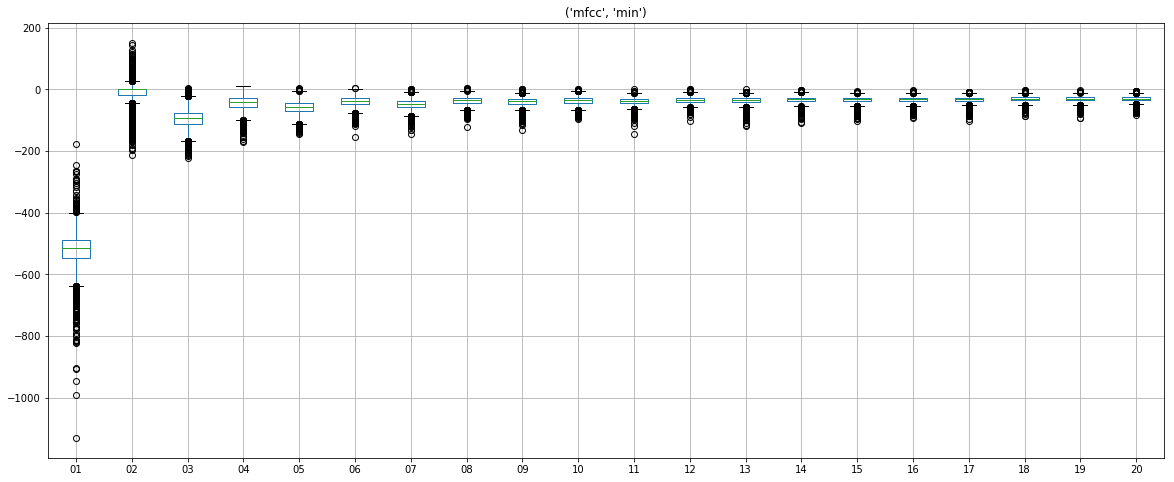

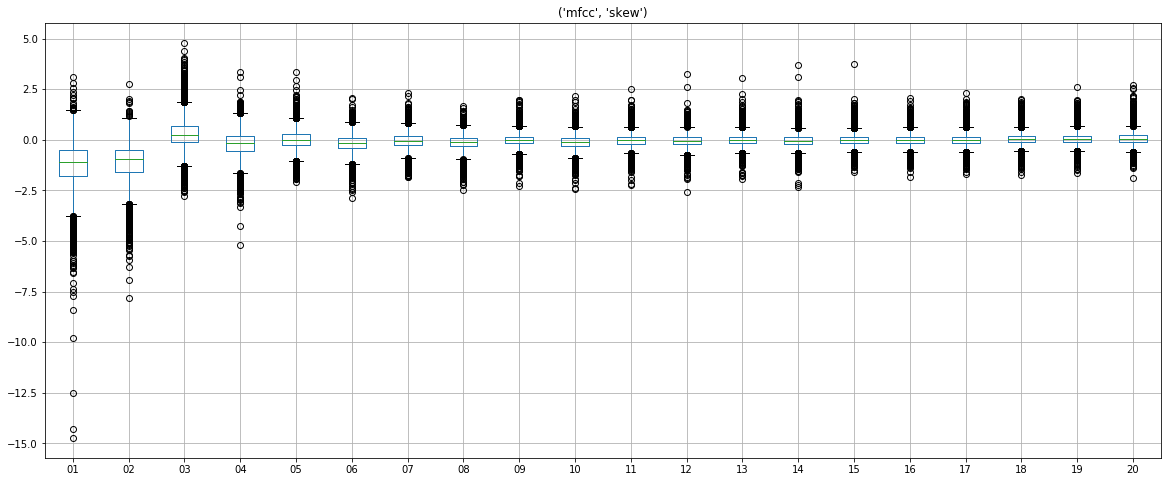

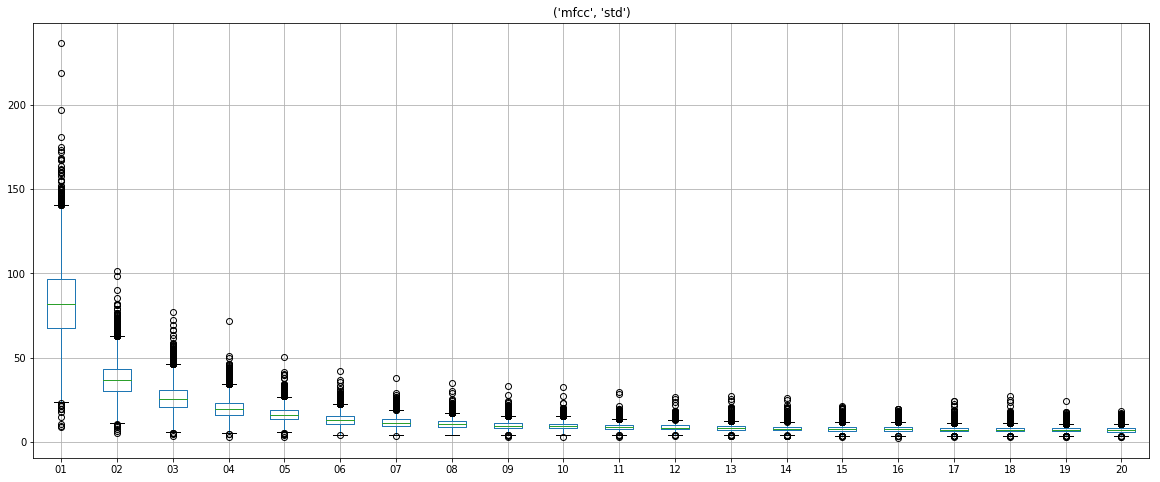

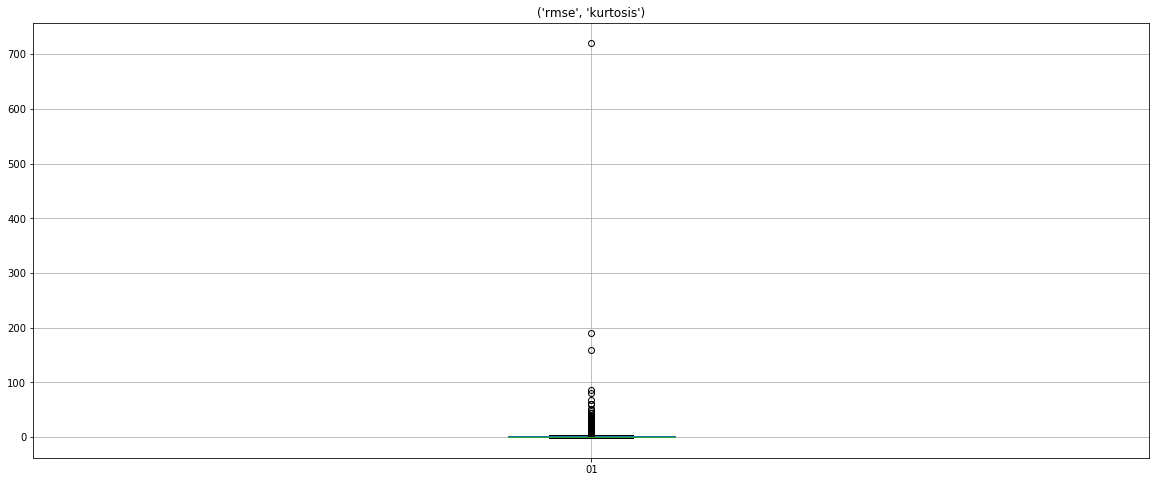

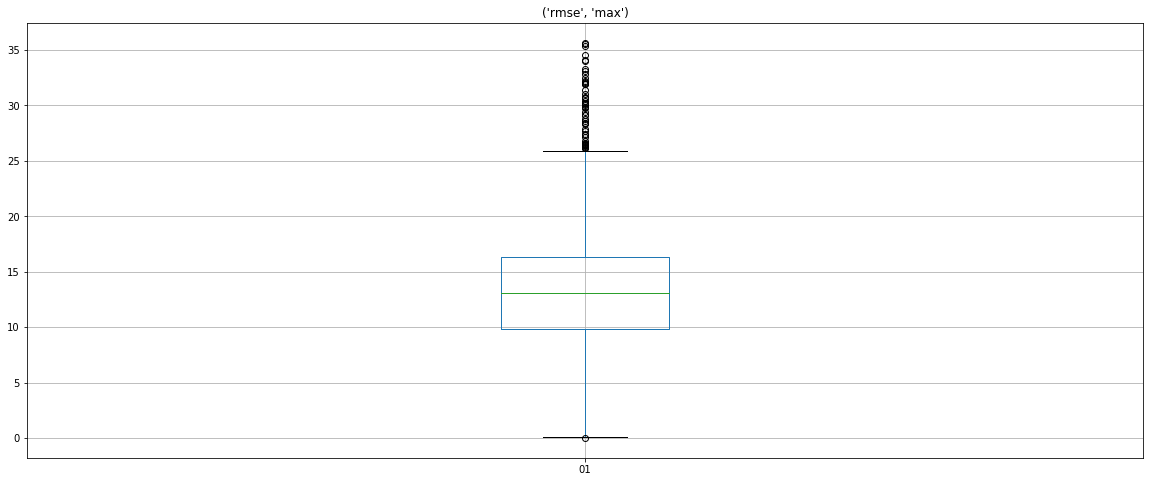

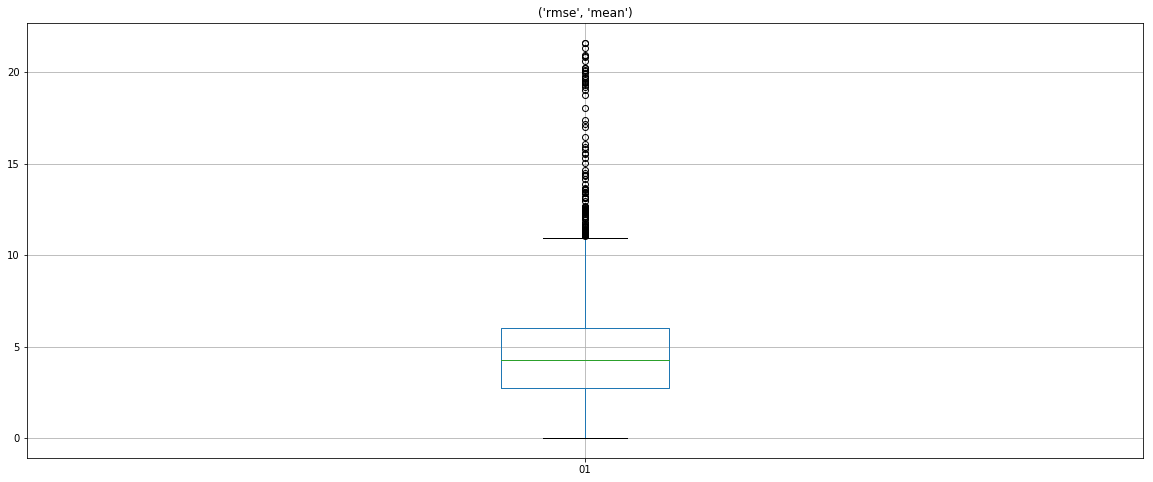

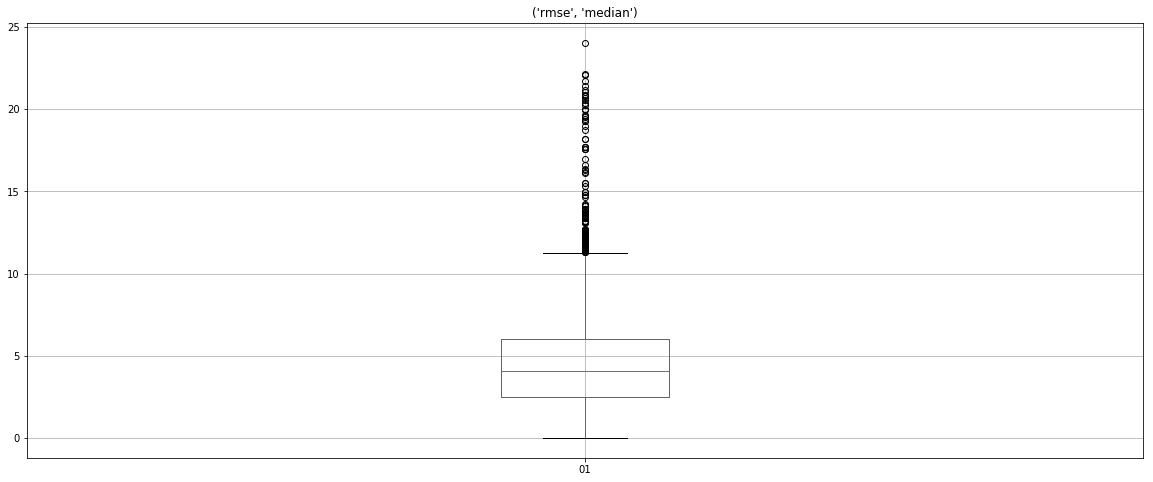

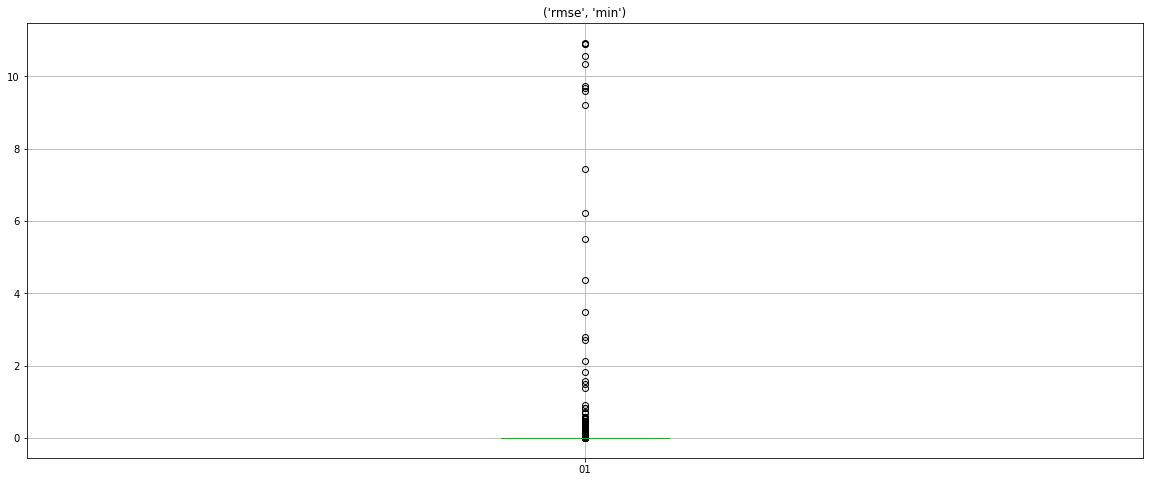

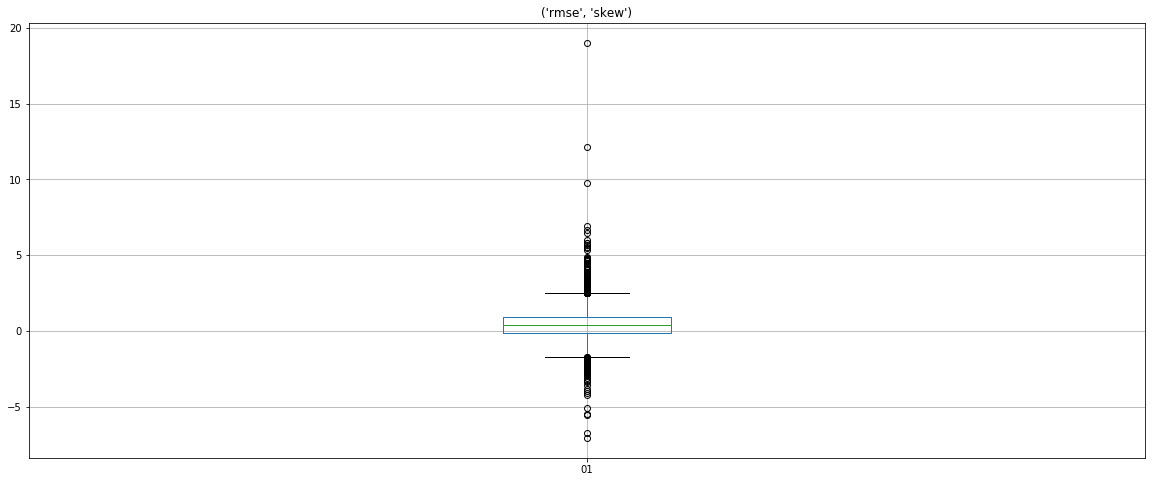

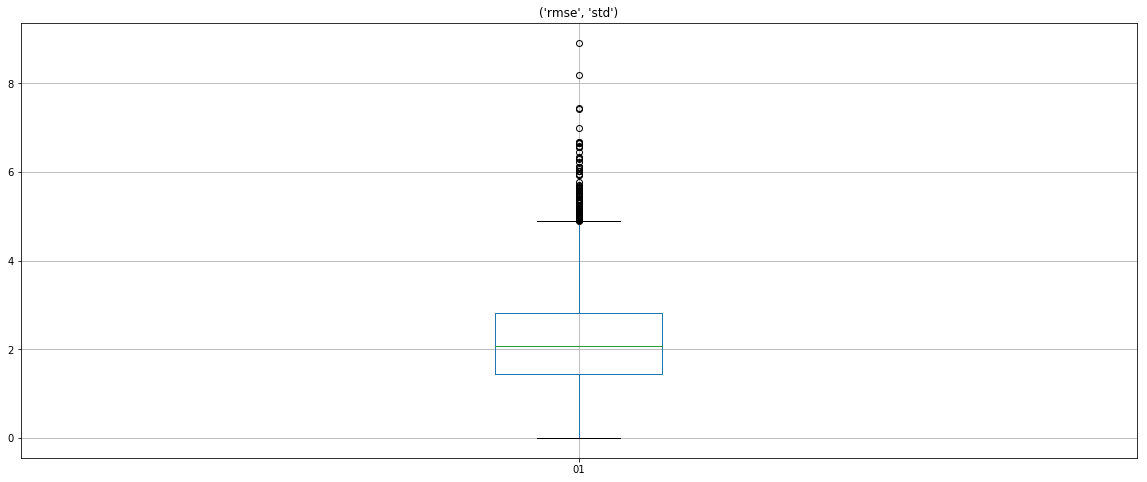

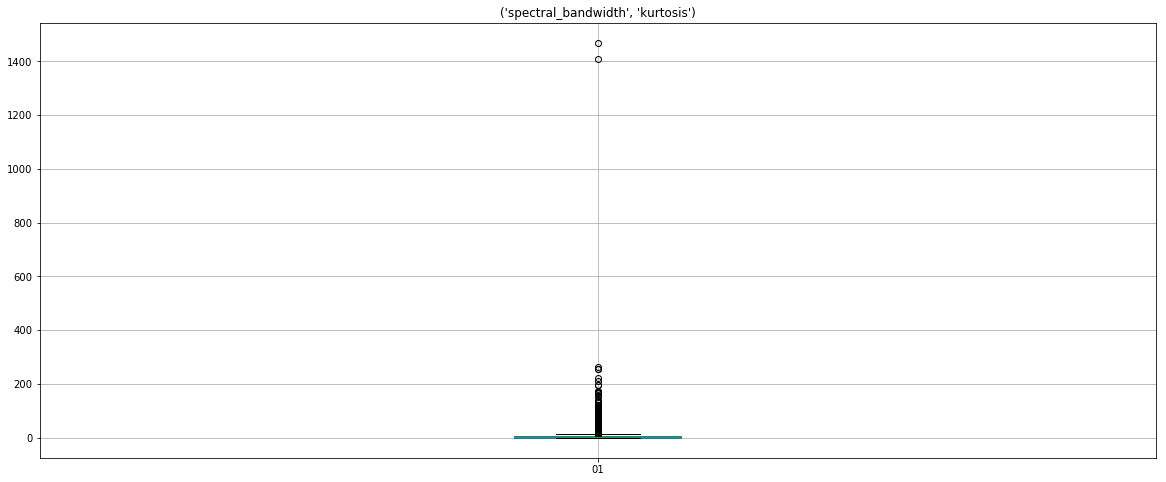

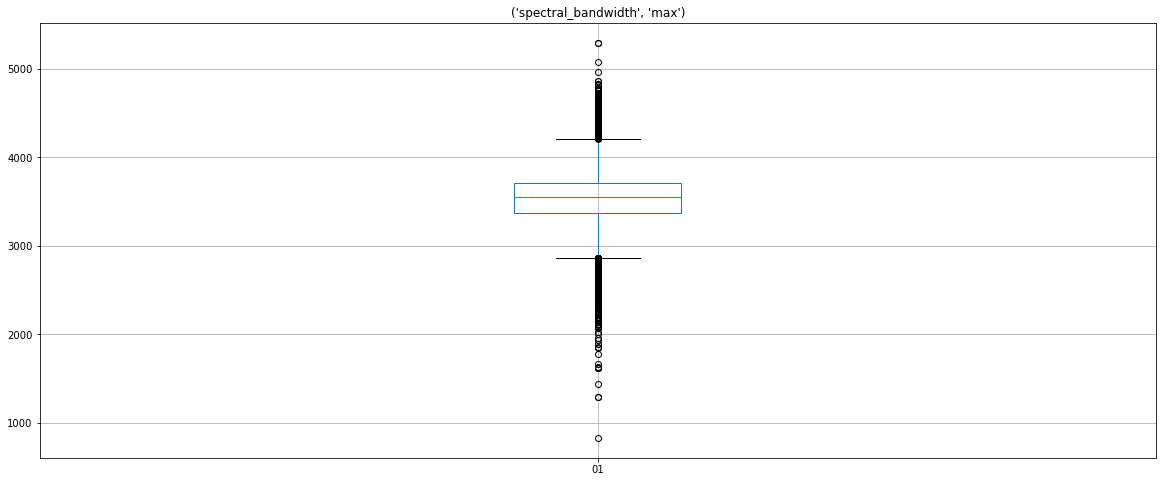

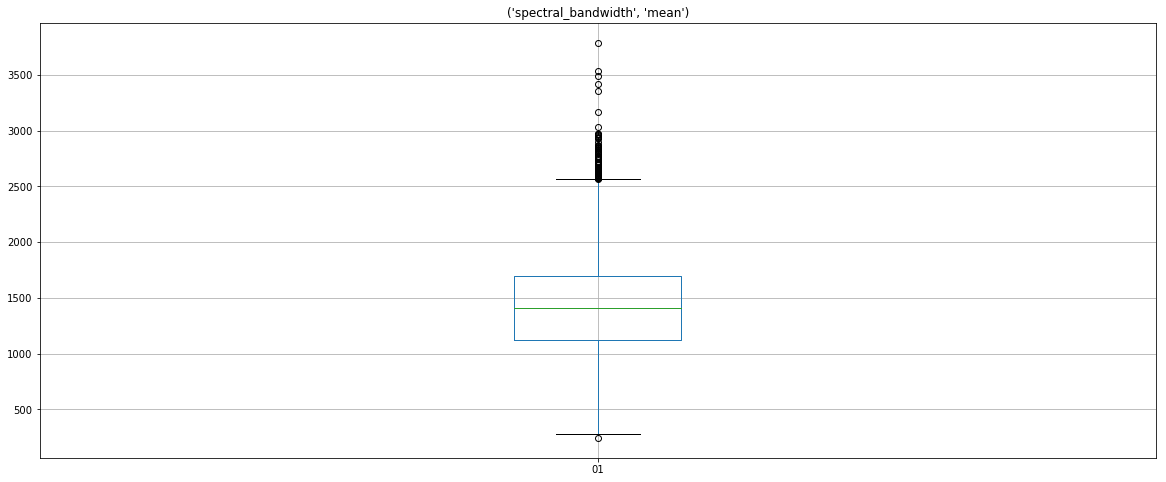

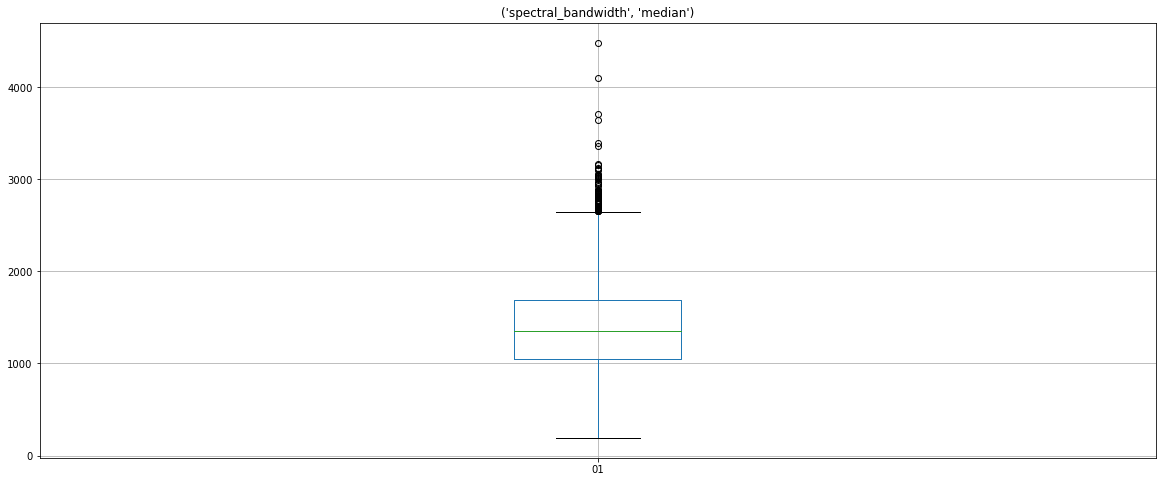

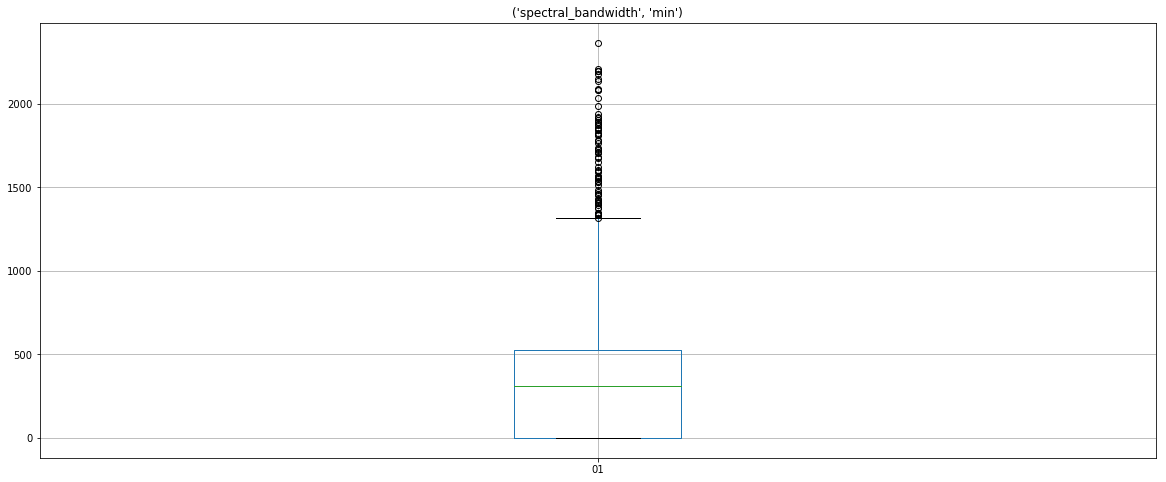

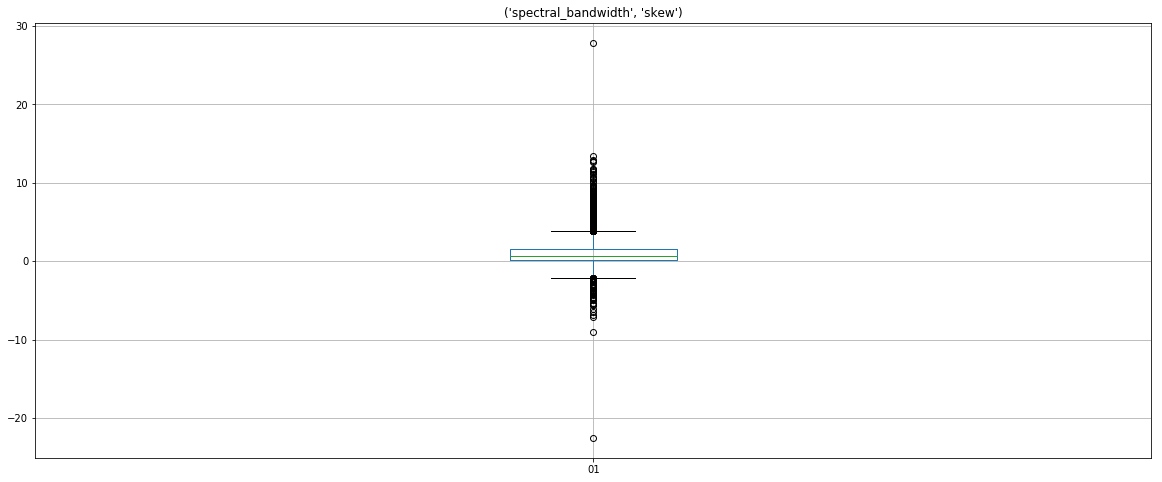

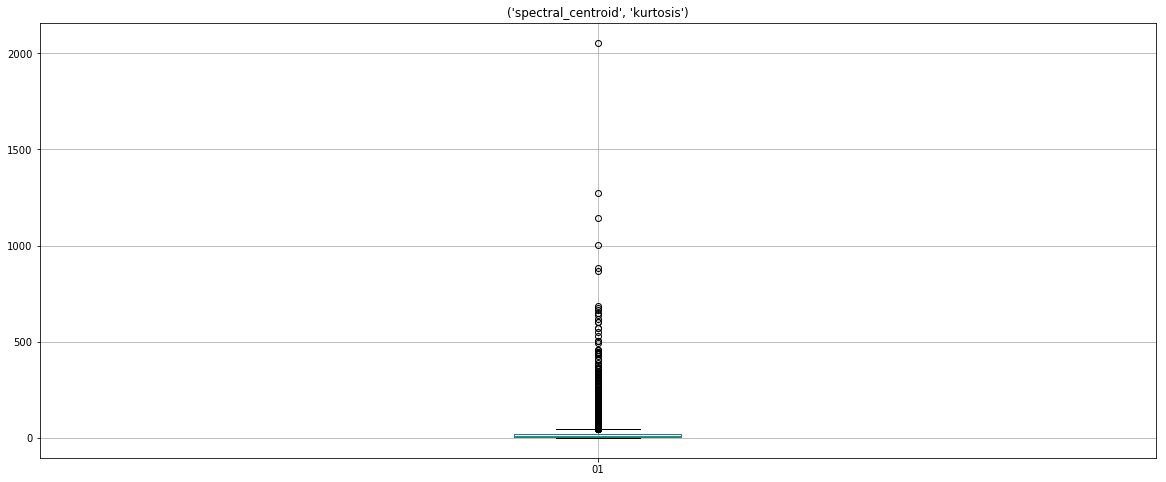

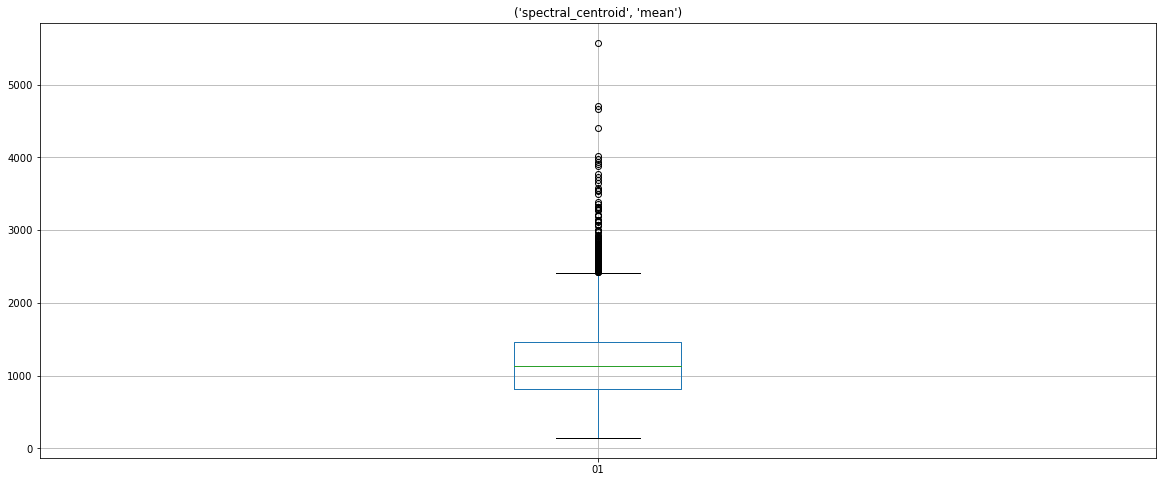

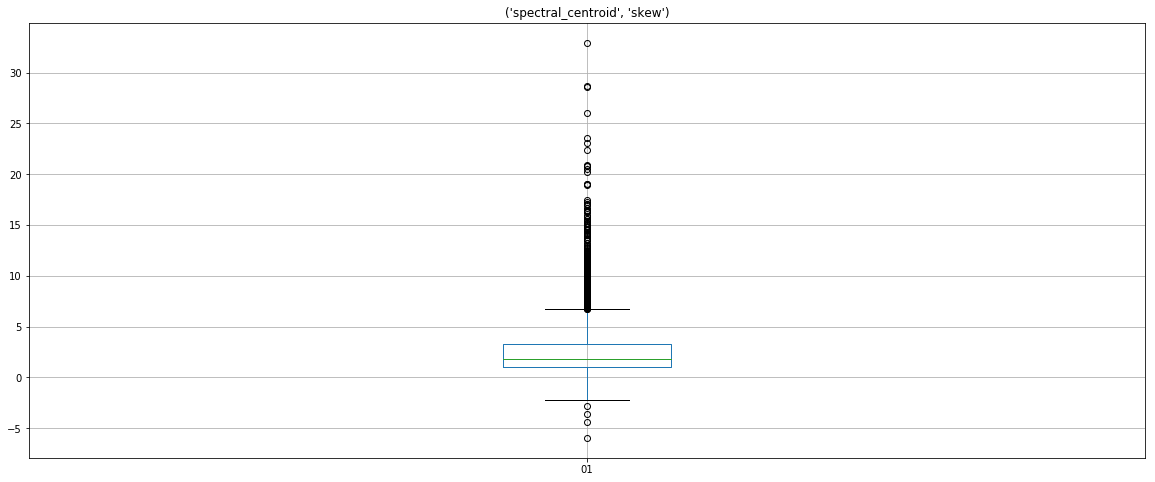

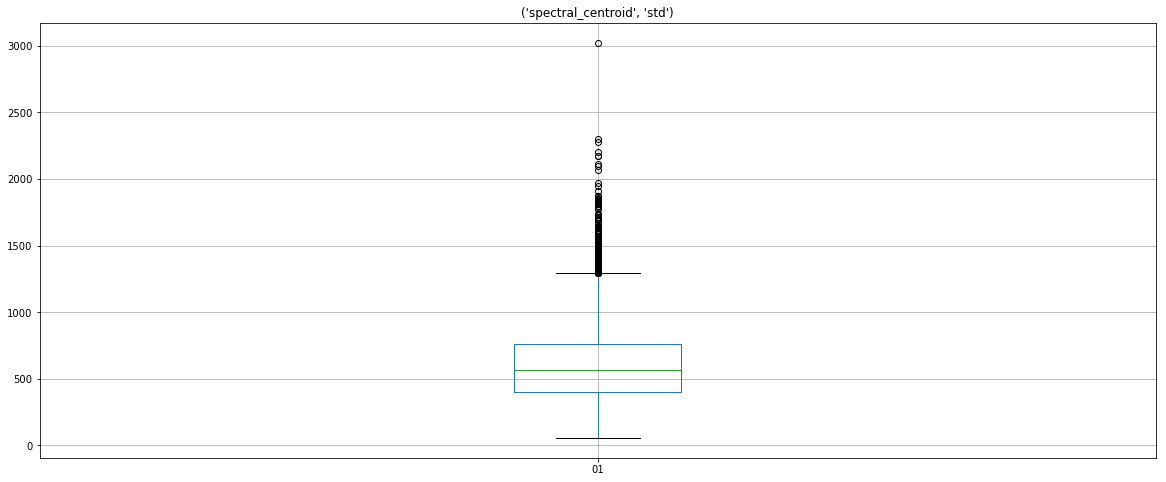

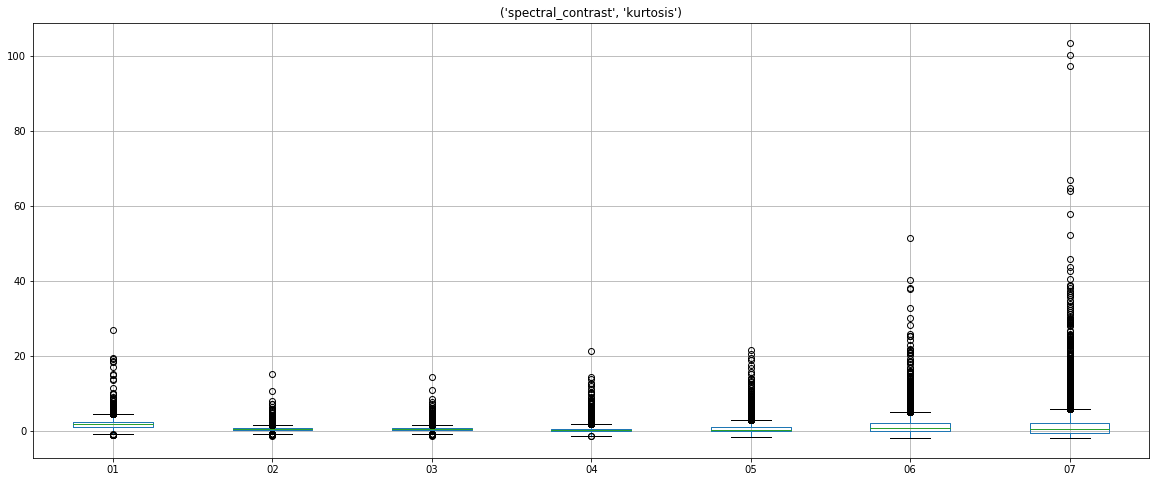

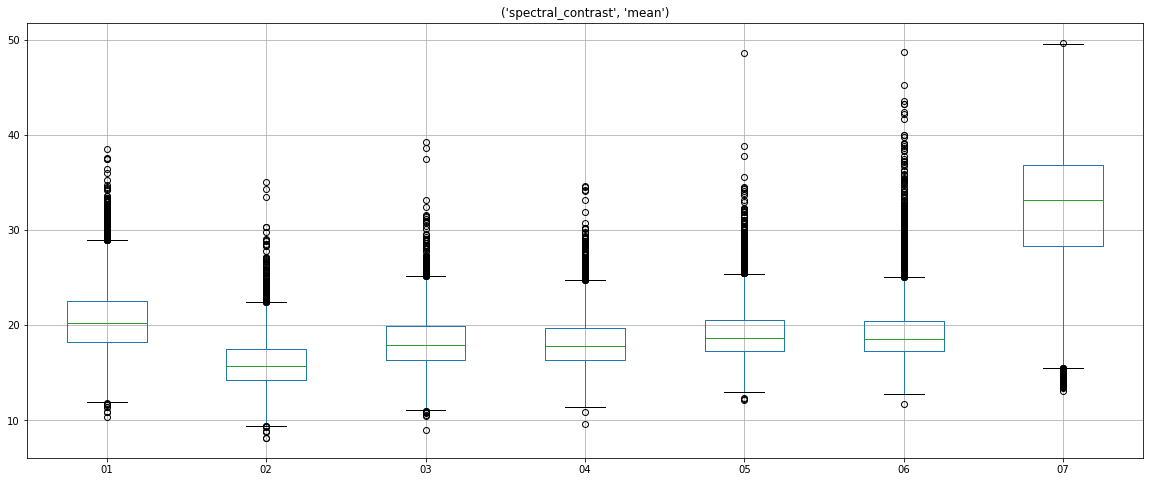

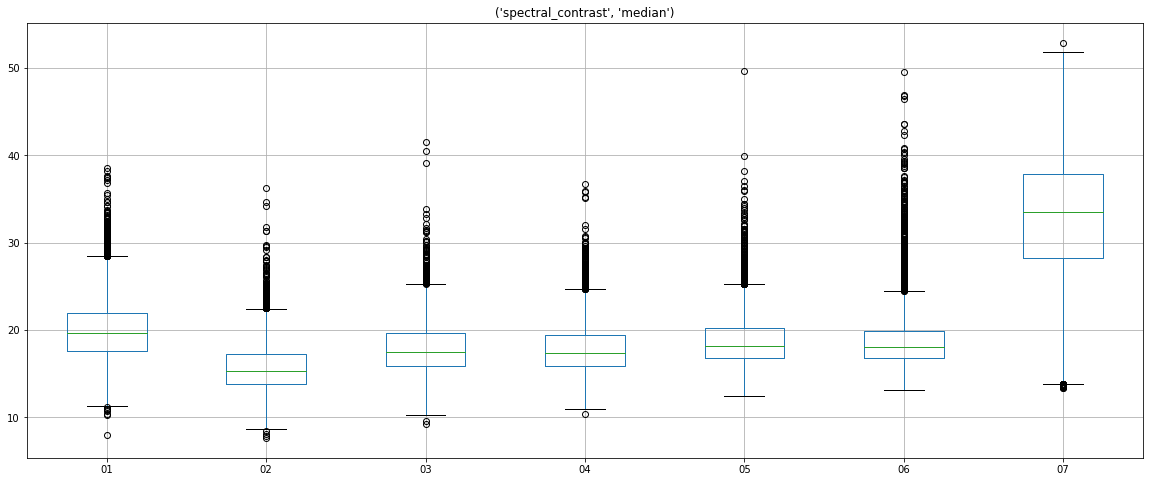

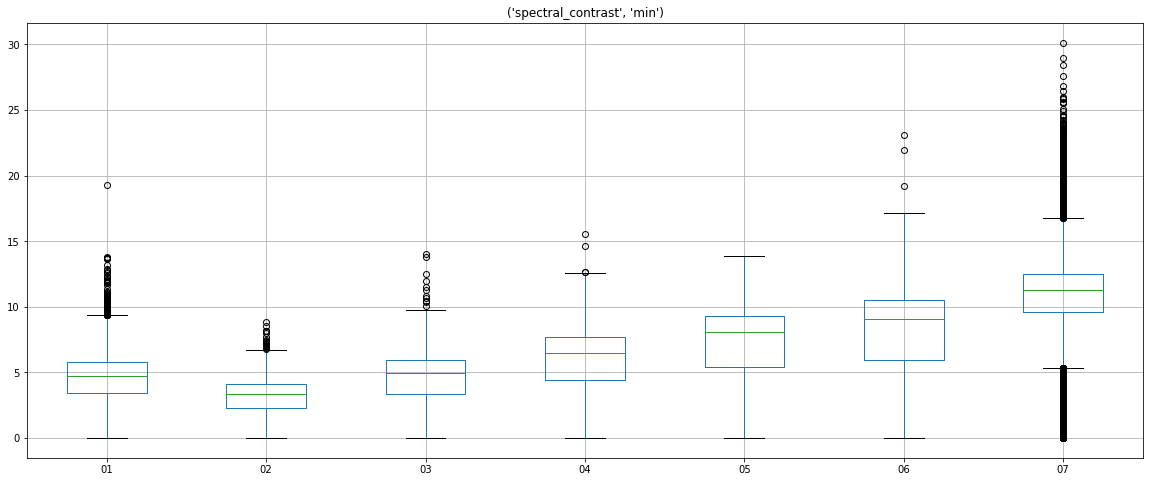

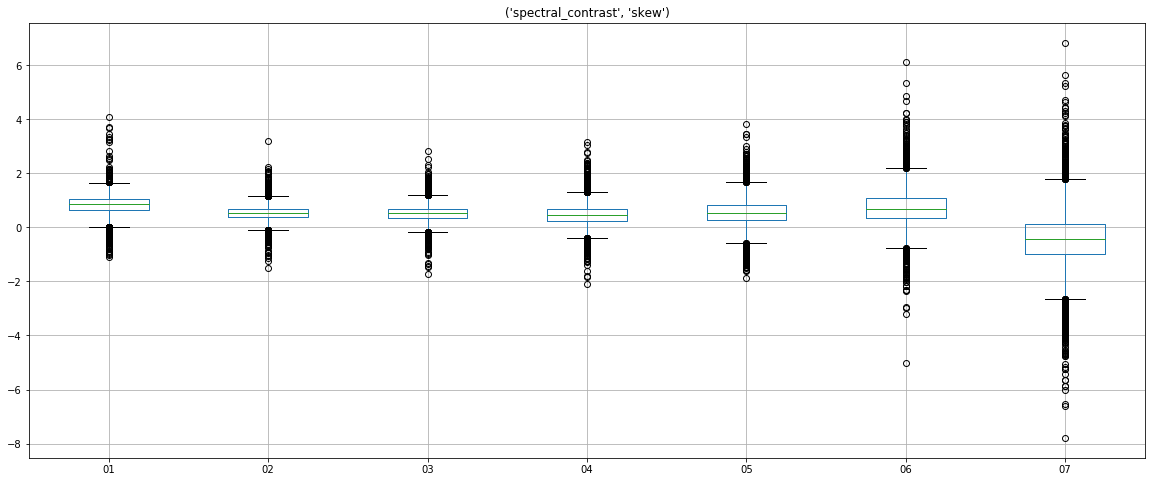

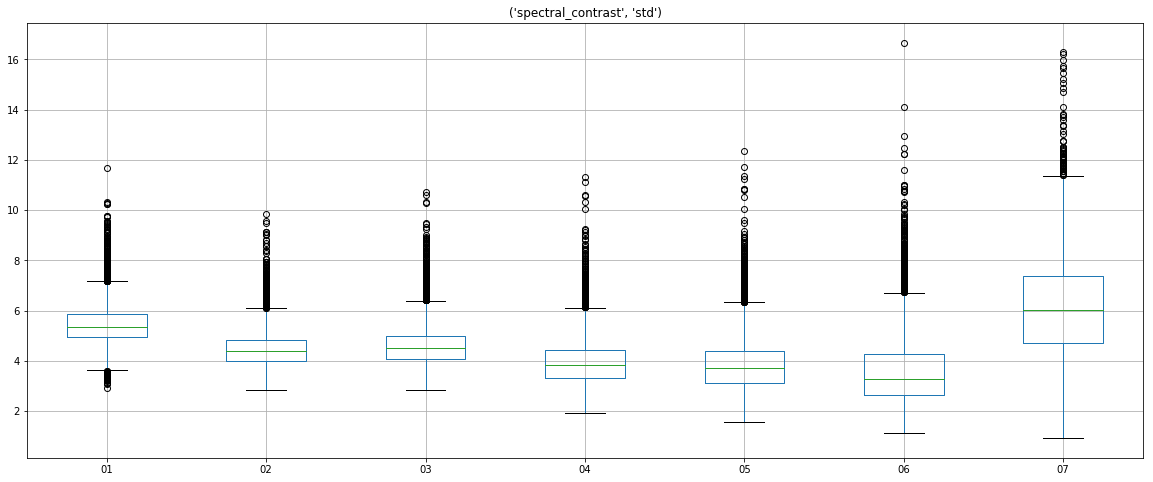

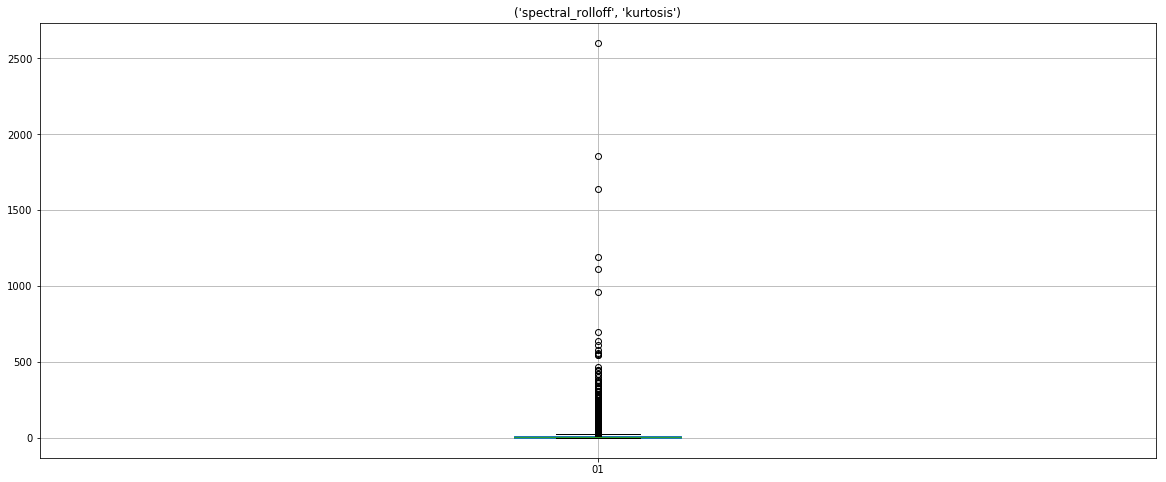

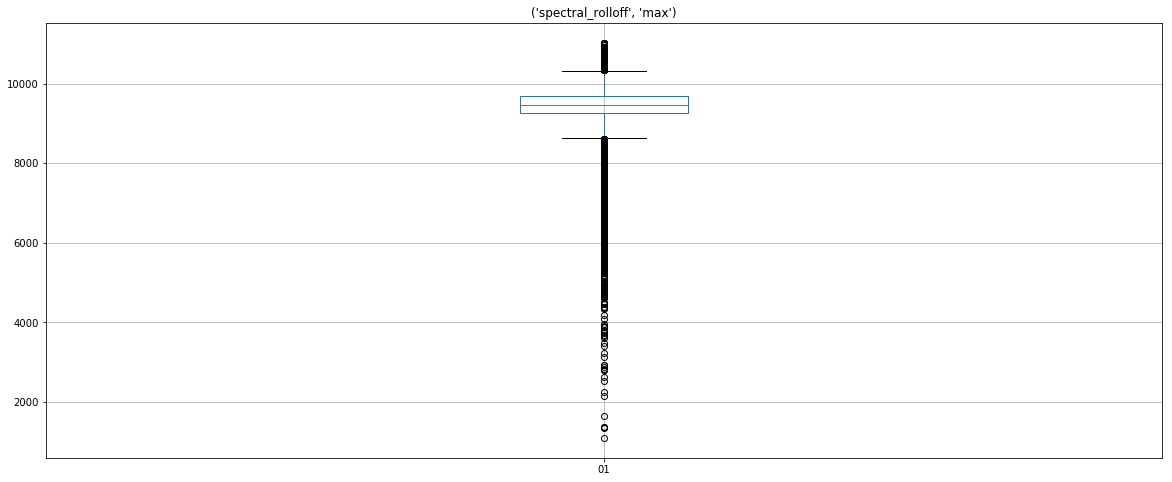

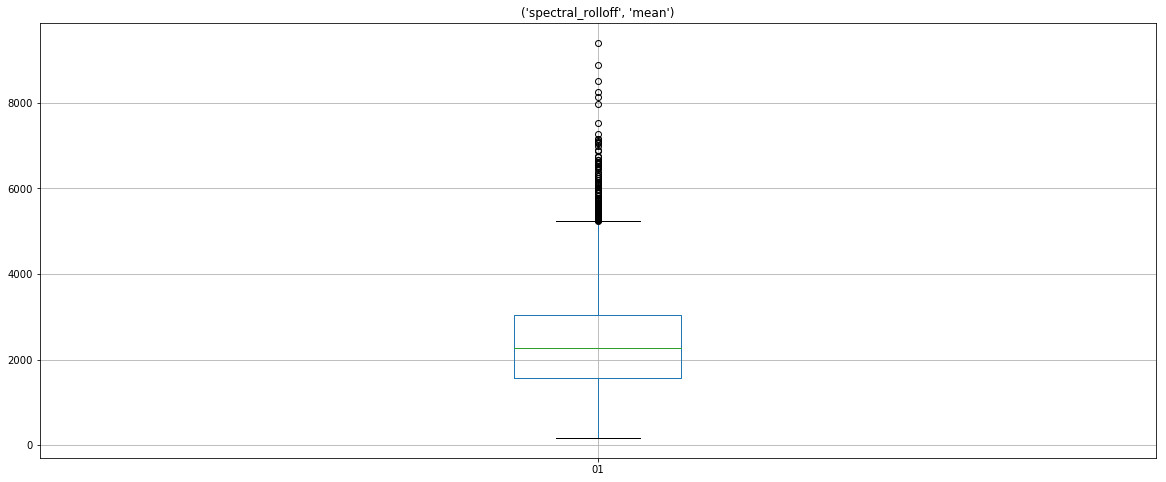

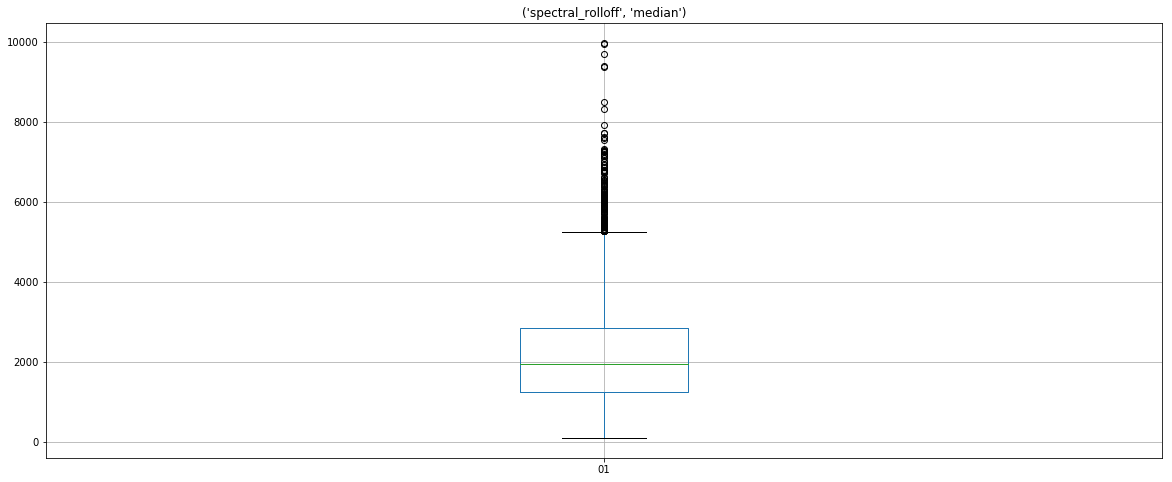

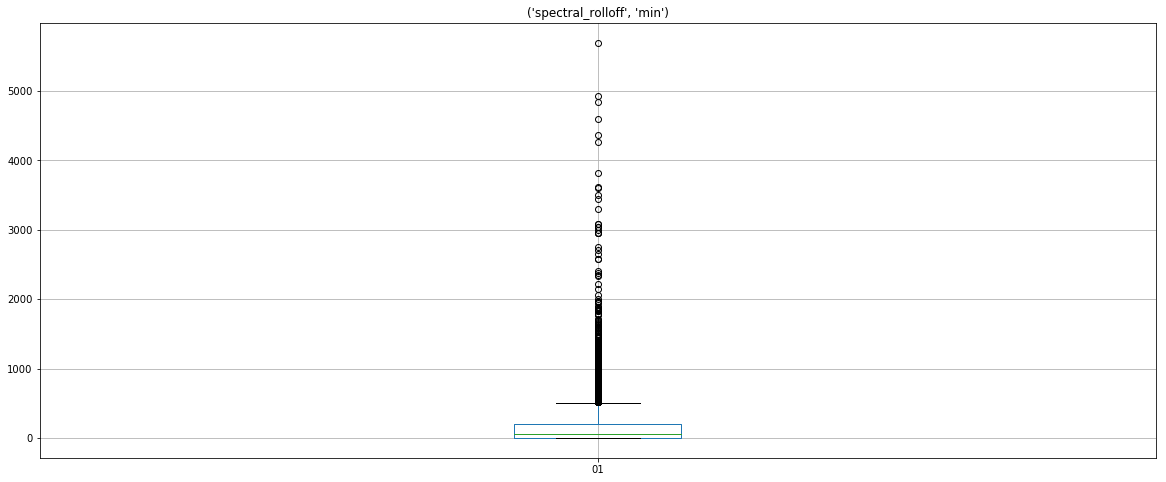

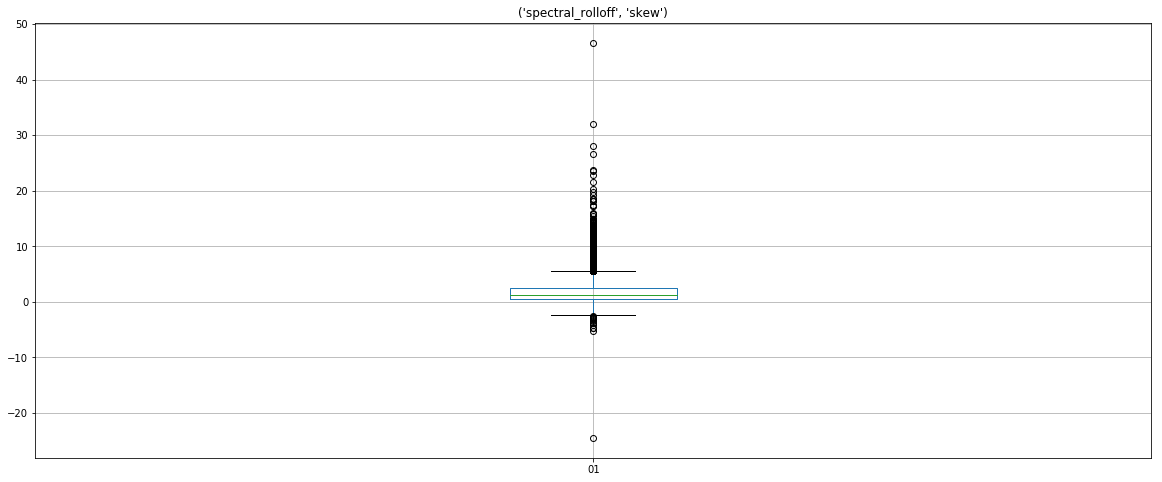

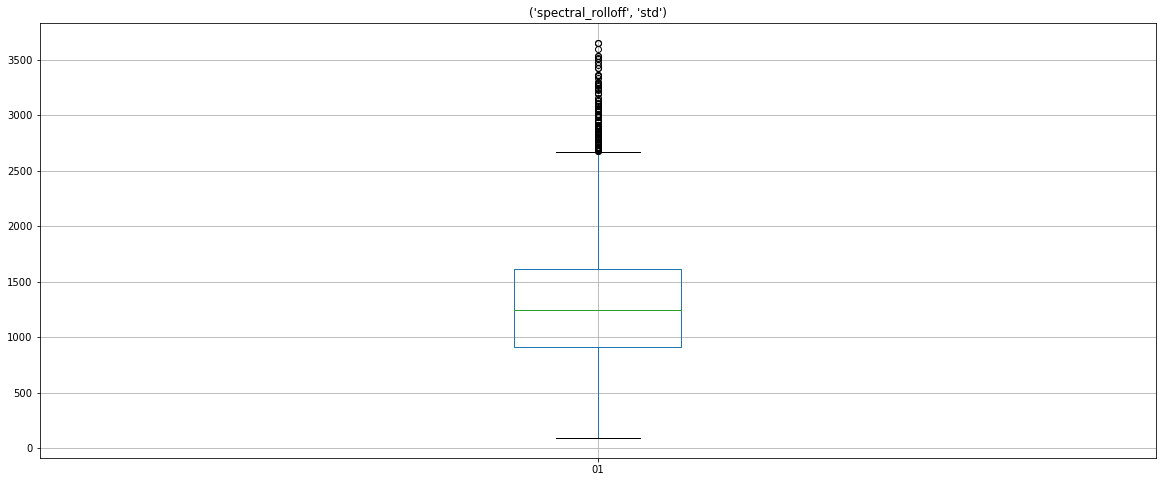

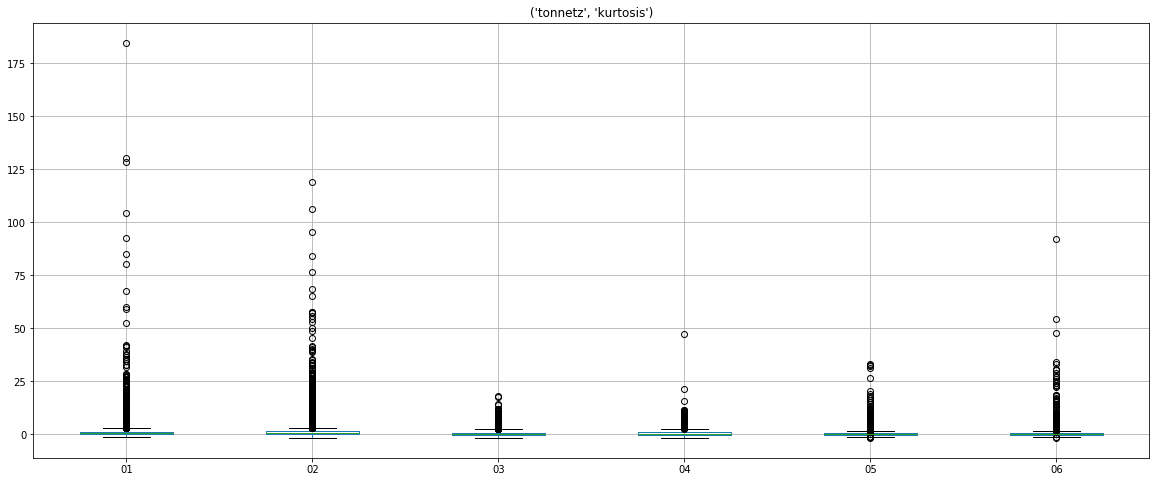

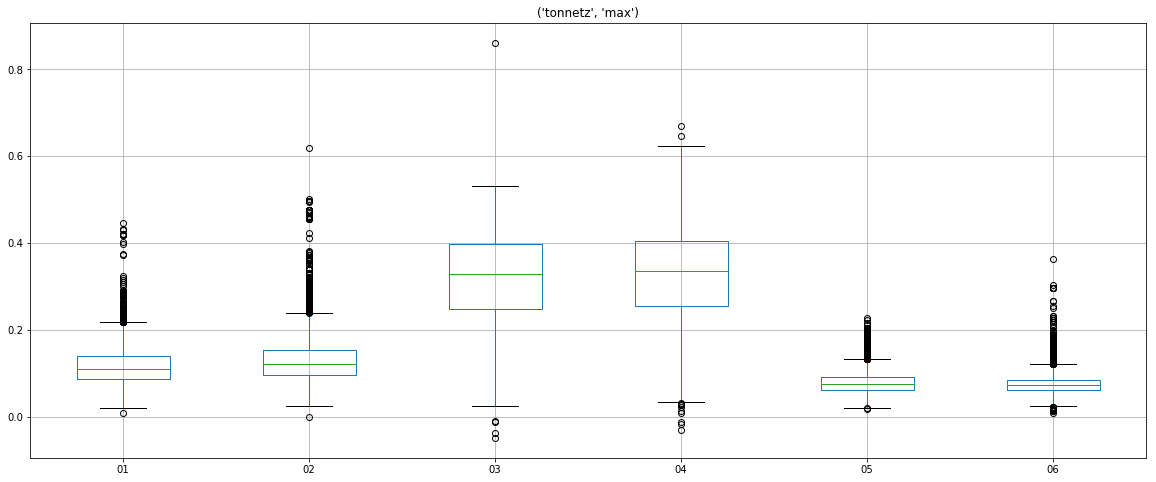

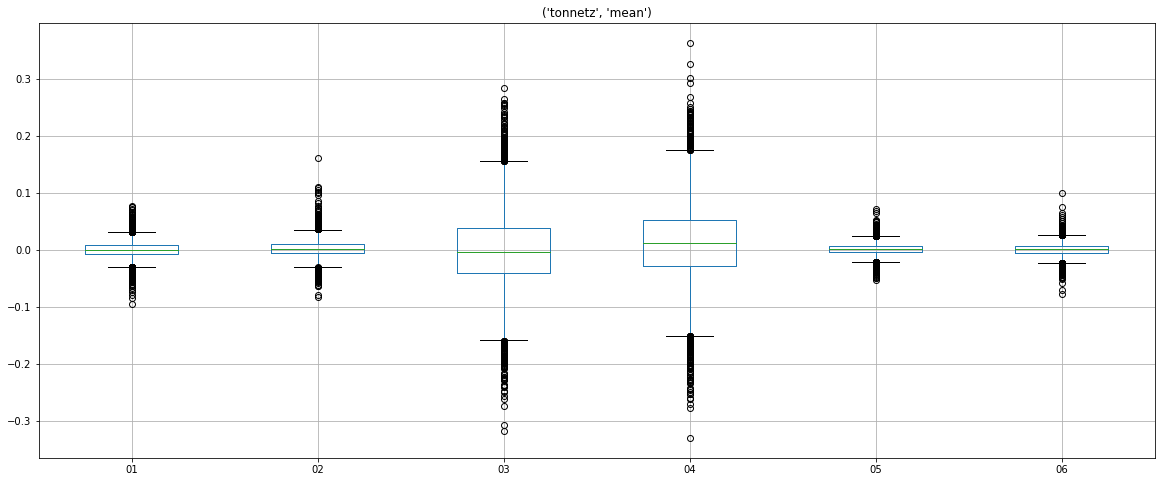

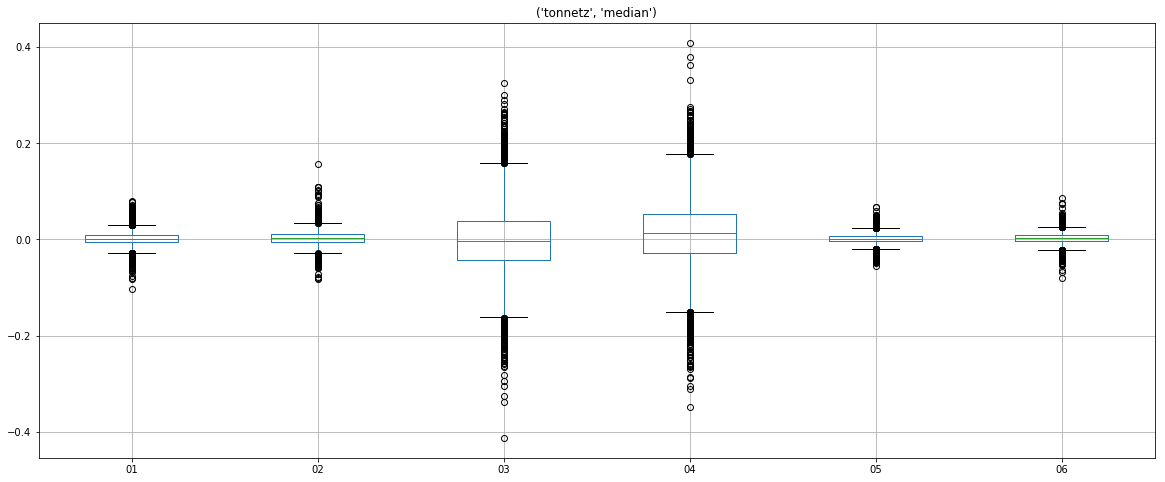

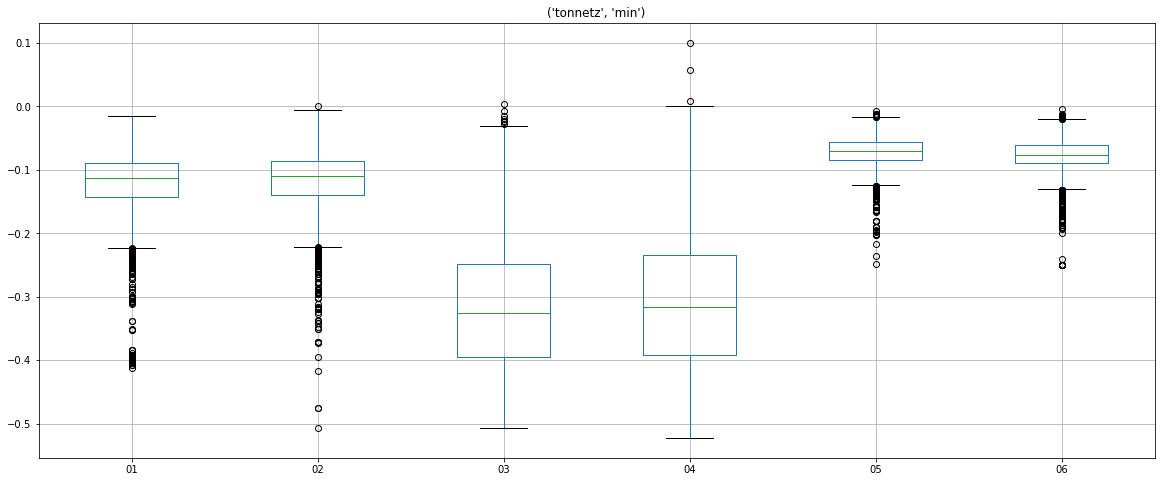

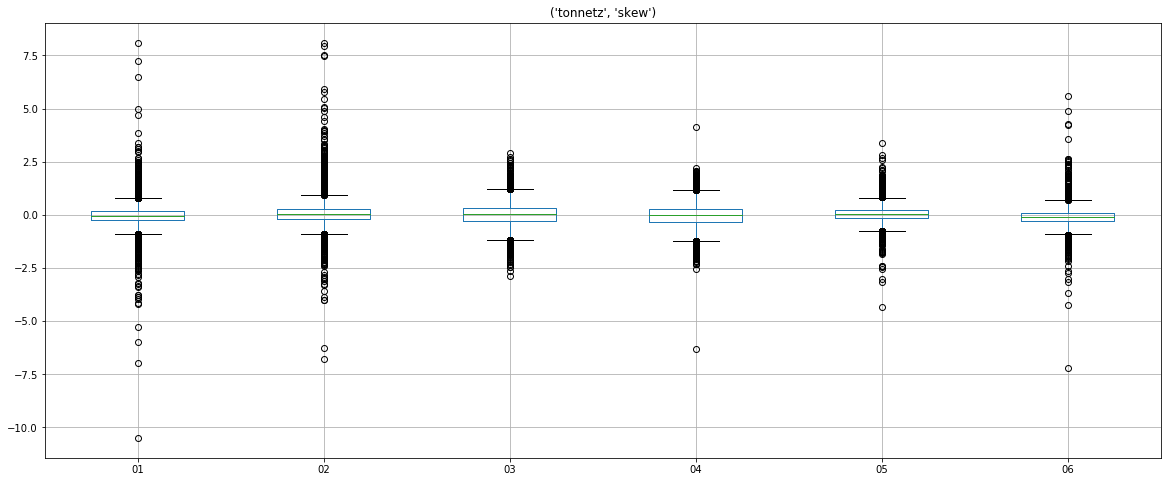

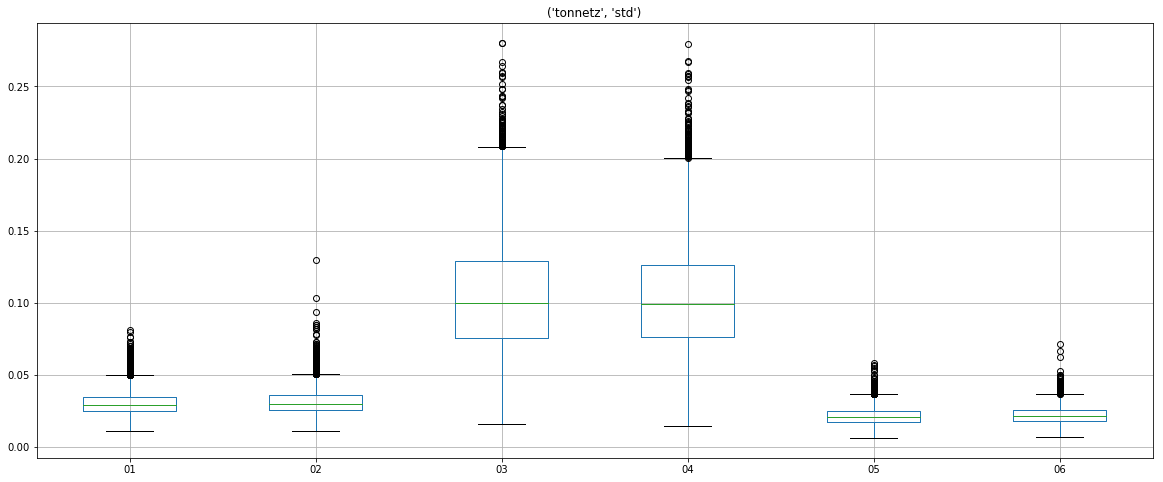

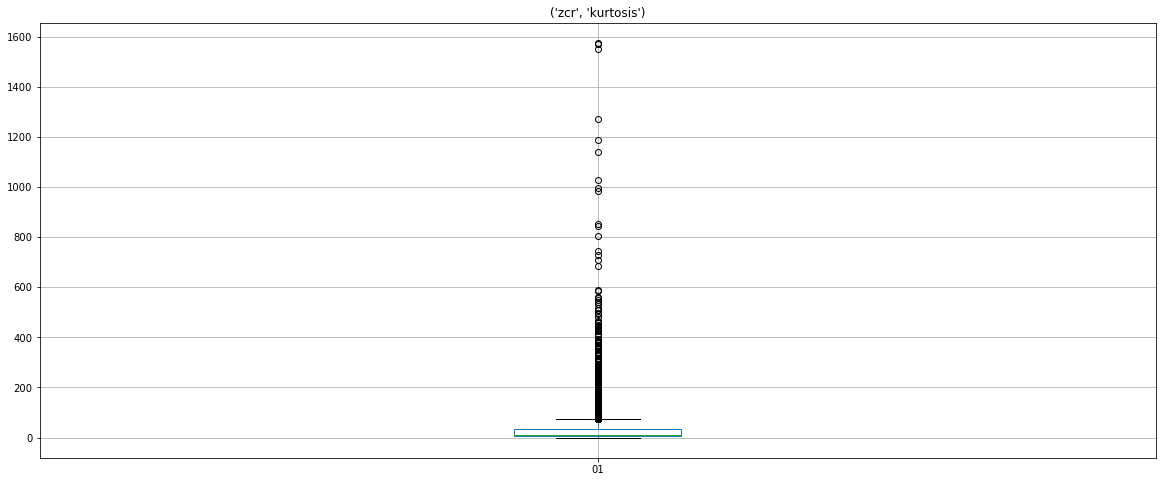

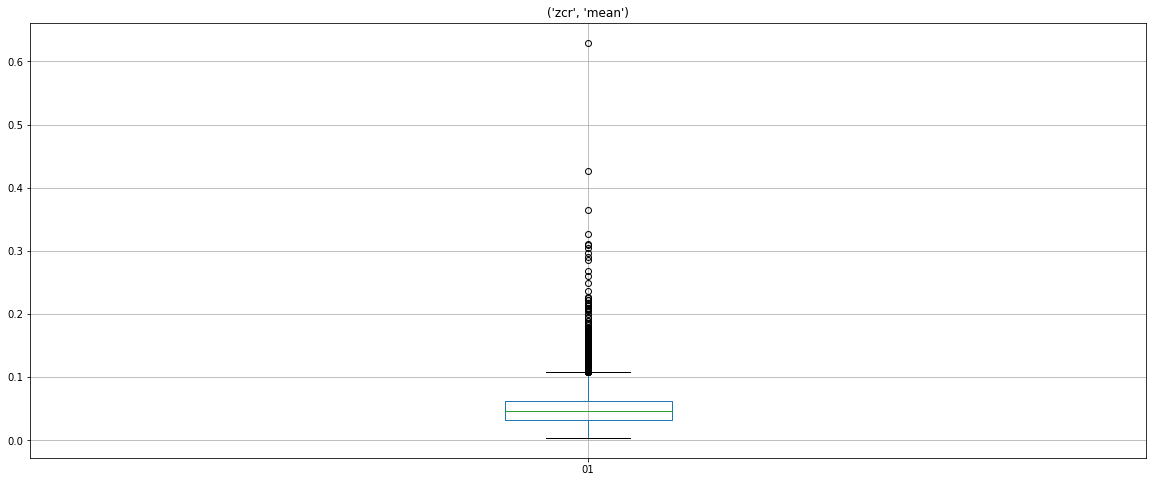

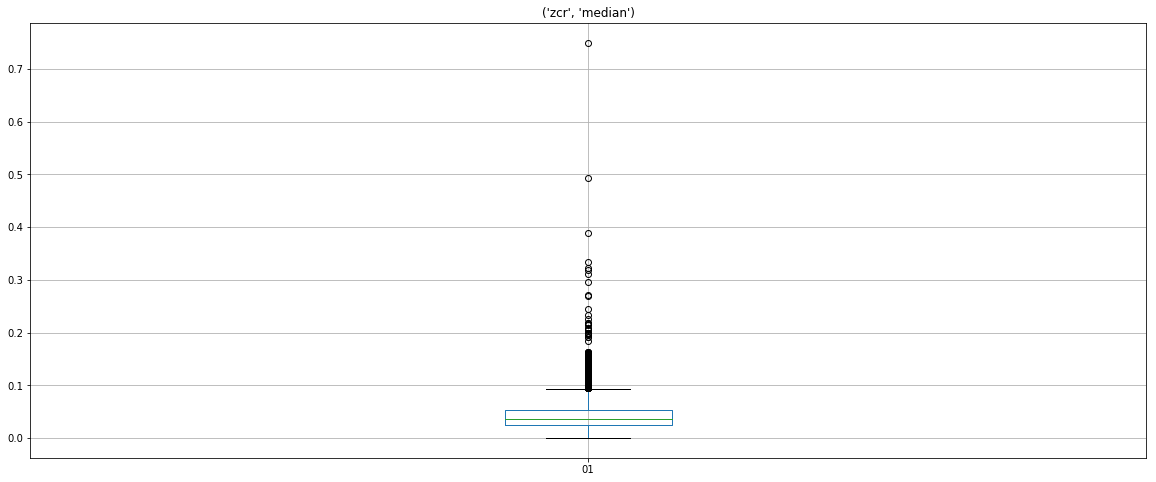

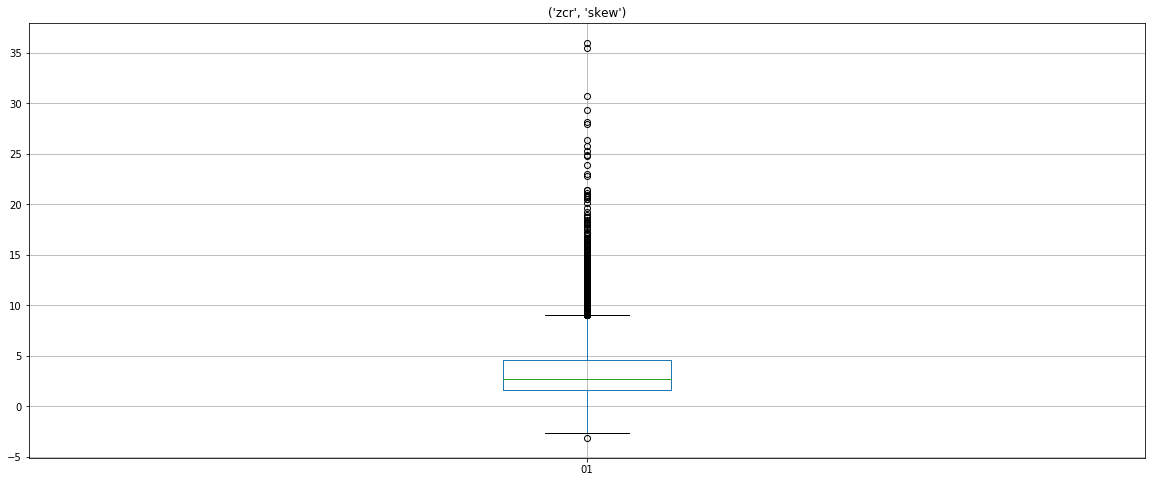

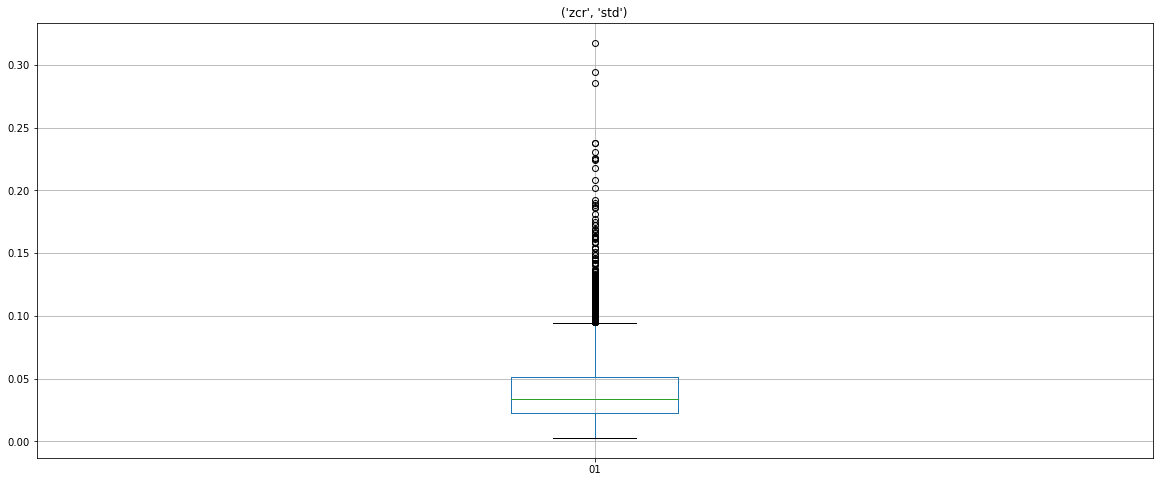

In [9]:
for a in group:
    subset = features[a[0]][a[1]]
    plt.figure(figsize=(20, 8))
    boxplot = subset.boxplot()
    plt.title(a)
    plt.show()

Based on this, we can remove songs which seems to be outliers (there is only few of them = 16/7995). In a future notebook, we will try to improve scaling, cleaning but for now, the objective is only to see if it outperform our previous models

In [10]:
features = features[ features['chroma_cens']['kurtosis']['03'] < 150 ]
features = features[ features['chroma_cens']['kurtosis']['08'] < 150 ]
features = features[ features['chroma_cens']['kurtosis']['11'] < 150 ]

features = features[ features['chroma_cqt']['kurtosis']['03'] < 150 ]

features = features[ features['chroma_stft']['kurtosis']['01'] < 150 ]

features = features[ features['chroma_stft']['skew']['01'] > -25 ]

features = features[ features['mfcc']['kurtosis']['01'] < 100 ]
features = features[ features['mfcc']['kurtosis']['02'] < 100 ]

features = features[ features['rmse']['kurtosis']['01'] < 100 ]

features = features[ features['spectral_bandwidth']['kurtosis']['01'] < 400 ]

### Preparation

In [11]:
tracks = tracks[tracks.index.isin(features.index)]

First let's scale feature. For now, we will apply MinMaxScaling for all features. We don't apply log transformation or Standard Scaling. This may improve performances but this is not the question yet.

In [12]:
X = MinMaxScaler().fit_transform(features)

In [13]:
index_song = features.index.values

Now, let's reduce dimensions as much as possible

In [14]:
pca = PCA(n_components=0.99)
new_X = pca.fit_transform(X)

In [15]:
X.shape

(7979, 518)

In [16]:
new_X.shape

(7979, 284)

PCA is quite efficient here, we reduce dimensions by 46% by losing only 1% of the variance. To finish let's encode and split the dataset to train/test

In [17]:
y = tracks[("track", "genre_top")].values

In [18]:
enc = LabelBinarizer()
y_enc = enc.fit_transform(y.reshape(-1, 1))

In [19]:
X_train, X_test, y_train, y_test, y_enc_train, y_enc_test = train_test_split(new_X, y, y_enc, test_size=0.20, random_state=42)

# Models

We can now try some models

In [20]:
clf = SVC()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.5047783174056086
0.5025062656641605


In [21]:
clf = LinearSVC(multi_class = "crammer_singer")

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6763277455741814
0.5632832080200502


In [22]:
clf = LogisticRegressionCV(multi_class="multinomial")

clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6293279022403259
0.5720551378446115


In [23]:
for depth in range(5, 12):
    clf = RandomForestClassifier(n_estimators = 50, max_depth=depth)
    clf.fit(X_train, y_train)
    print("\nDepth:", depth)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


Depth: 5
0.5965846780510732
0.4780701754385965

Depth: 6
0.6428011906626978
0.46365914786967416

Depth: 7
0.7380542064859784
0.4630325814536341

Depth: 8
0.8030706564311453
0.4617794486215539

Depth: 9
0.8987936706877644
0.4692982456140351

Depth: 10
0.9454801817327275
0.4674185463659148

Depth: 11
0.9807300642331193
0.46365914786967416


In [24]:
for depth in range(5, 12):
    clf = ExtraTreesClassifier(n_estimators = 50, max_depth=depth)
    clf.fit(X_train, y_train)
    print("\nDepth:", depth)
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


Depth: 5
0.5903180322732258
0.44799498746867167

Depth: 6
0.6501644994516685
0.4492481203007519

Depth: 7
0.7336675544414852
0.4548872180451128

Depth: 8
0.8044806517311609
0.46365914786967416

Depth: 9
0.8654237819207269
0.4473684210526316

Depth: 10
0.9163402788657371
0.45802005012531327

Depth: 11
0.9461068463105123
0.4605263157894737


In [25]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='custom_activation'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='custom_activation'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               36480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 40,872
Trainable params: 40,872
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", "accuracy"])

In [27]:
history = model.fit(X_train, y_enc_train, 
                      epochs=25, 
                      batch_size=100, 
                      verbose=1, 
                      validation_data=(X_test, y_enc_test))

Train on 6383 samples, validate on 1596 samples
Epoch 1/25
6383/6383 [==============================] - 2s 289us/step - loss: 0.3415 - binary_crossentropy: 0.3415 - acc: 0.8766 - val_loss: 0.2933 - val_binary_crossentropy: 0.2933 - val_acc: 0.8839
Epoch 2/25
6383/6383 [==============================] - 0s 57us/step - loss: 0.2745 - binary_crossentropy: 0.2745 - acc: 0.8937 - val_loss: 0.2535 - val_binary_crossentropy: 0.2535 - val_acc: 0.9014
Epoch 3/25
6383/6383 [==============================] - 0s 54us/step - loss: 0.2484 - binary_crossentropy: 0.2484 - acc: 0.9028 - val_loss: 0.2402 - val_binary_crossentropy: 0.2402 - val_acc: 0.9052
Epoch 4/25
6383/6383 [==============================] - 0s 54us/step - loss: 0.2357 - binary_crossentropy: 0.2357 - acc: 0.9086 - val_loss: 0.2372 - val_binary_crossentropy: 0.2372 - val_acc: 0.9059
Epoch 5/25
6383/6383 [==============================] - 0s 54us/step - loss: 0.2277 - binary_crossentropy: 0.2277 - acc: 0.9122 - val_loss: 0.2356 - val_bi

I've done some triles with differents activation fonction at fixed topology 128 + D04 + 32 + D02 + 8S. For all of them I look at the sammlest test loss. Results are the following one :

- RELU = 0.2621395363470068
- ELU = 0.23712751105016933
- SWISH = 0.2321398657814303
- SELU = 0.2378648814178051
- tanh = 0.23728603737097337
- hard_sigmoid = 0.23761723707791857
- sigmoid = 0.23684624532111606
- linear = 0.24031202196327964

Results are quite good now with more than 90% accuracy of accucary. This is a good points because those features are easy to extract. We will try on a future notebbok to try it with more songs using the full dataset. In addition, having more datas will allow us to keep more dimensions without increasing overfitting. To finish this notebbok, let's check what are closest songs based on those scaled features

# Recommander

To do so, we will compute for a given song, all distances with other songs and take the closest one. As all values are scaled, we can use euclidean metric. Let's see the result.

In [28]:
def get_audio(index):
    song_str = "{0:06d}".format(index)
    folder = song_str[:3]

    base_song_path = "F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_small/"+folder+"/"+song_str+".mp3"
    y, sr = librosa.load(base_song_path, sr=None, mono = True)

    if sr != 22050:
        y = librosa.resample(y, sr, 22050)
        sr = 22050
    print("returning song {}".format(song_str))
    return y[:500000]

def create_playlist(index):
    vector = [new_X[index, :]]
    dist = cdist(new_X, vector)
    close_index = np.argsort(dist.flatten())[1]
    index_base_song = index_song[index]
    index_close_song = index_song[close_index]
    
    y_orig = get_audio(index_base_song)
    y_closest = get_audio(index_close_song)
    
    return y_orig, y_closest

In [29]:
y1, y2 = create_playlist(42)

returning song 000707
returning song 000705


In [30]:
ipd.Audio(y1, rate=22050)

In [31]:
ipd.Audio(y2, rate=22050)

We can hear that both audio have the same energy but they are still differents. Nevertheless it's still similar.

In [32]:
y1, y2 = create_playlist(31)

returning song 000621
returning song 054665


In [33]:
ipd.Audio(y1, rate=22050)

In [34]:
ipd.Audio(y2, rate=22050)

This prediction is better, we have in both case an acoustic song. One has more echo but there are correct. We have also to keep in mind that we have access to ONLY 8K audio samples of 30s. With more audio, we can find closest ones.

In [35]:
y1, y2 = create_playlist(1)

returning song 000005
returning song 119578


In [36]:
ipd.Audio(y1, rate=22050)

In [37]:
ipd.Audio(y2, rate=22050)

The last audio looks very differents but the second song change after 15s to another one more similar. This can be strange for the listener but at the end they are also similar.

# Conclusion

In this notebook, we used meta data easy to extract from audio in order to classify song with their genre and also to do a recommander. This is not perfect but we may imagine extracting those features every 10s and then use RNN on a input of  60 timesteps x 584 features. This may help having better prediction if the audio change during time. Based on the result we have here, this is more likely what we have to do. This will be done after exploring dataset more in detail with R. The idea of this exploration is to find if we should convert to log some features for example.